# Predicting bioactivity of potential ligands with transglutaminase 2 (Celiac Disease)

*Ibrahim Wichka & Prof. Pin-Kuang Lai (Stevens Institute of Technology)*

## Step 1: Data Preprocessing

1.1: Import dataset and libraries and begin to clean dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [ ]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#----------------------------------------------------
import numpy as np
import pandas as pd

*** Note: The following cell contains instructions that do not need to be done to go through this tutorial. I am simply including it for the purpose of articulating data finding techniques

We must use a dataset from a biological assay of compounds tested against transglutaminase 2 (TG2). Many of these can be found on databases like:

CHEMBL (https://www.ebi.ac.uk/chembl/)
PubChem (https://pubchem.ncbi.nlm.nih.gov/)

We can get our dataset from Pubchem's TG2 assays and download a csv of it:

Pubchem Data Link:(https://pubchem.ncbi.nlm.nih.gov/gene/7052#section=Chemicals-and-Bioactivities&fullscreen=true)

CSV File: https://drive.google.com/file/d/118BhVnxCtB6jjo44cHrxVrKo_mYI4WWQ/view?usp=sharing


This dataset contains many columns but the only ones that we will really need are CID, Compound_Name, Type, Value, and Activity.

One thing not present in the dataset are the SMILES notation for all the molecules. These can be extracted from pubhcem manually put because our dataset is so large, this would be time consuming.

We can use the pubchempy api to get the smiles of all the molecules in the dataset. Here is a link to a notebook with a demonstration of this.

*** Note: The following instructions are mandatory.

For this tutorial simply download the file:  

CSV File: https://drive.google.com/file/d/1AJdjYbAE3cMFliJOib3Dc_u86JXn5-au/view?usp=sharing


Place it into the sample data for your demo of this tutorial.

You are now ready to do some bioactivity predictions!

Store the csv in a dataframe.

In [ ]:
df_master = pd.read_csv('TG2_compound_smiles.csv')
df_master

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,CC1=C(C2=C(S1)N=C(N(C2=O)C3=CC=CC=C3)SCC(=O)NN...
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,C1CC(C2=C(C1)SC3=C2C(=O)N(C(=N3)SCC(=O)NN)C4=C...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,C1=CC=C(C(=C1)C2=C(SC3=C2C(=O)N(C(=N3)SCC(=O)N...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COC1=CC=C(C=C1)C2=CSC3=C2C(=O)N(C(=N3)SCC(=O)N...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,C1=CC=C(C=C1)C2=CSC3=C2C(=O)N(C(=N3)SCC(=O)NN)...
...,...,...,...,...,...,...,...
1125,5387156,(2E)-3-(3-nitrophenyl)-1-(pyridin-3-yl)prop-2-...,IC50,19.60,Unspecified,=,C1=CC(=CC(=C1)[N+](=O)[O-])C=CC(=O)C2=CN=CC=C2
1126,72950407,T4SR539Ykf,IC50,0.01,Unspecified,>,CCC(CC)CNC(=O)CN1C=CC=C(C1=O)NC(=O)C(CCC=CC(=O...
1127,146197612,Ac-Asn-Abu(Unk)-Glu-Gln-Val-Ser-Pro-Leu-OH,IC50,0.01,Unspecified,>,CC(C)CC(C(=O)O)NC(=O)C1CCCN1C(=O)C(CO)NC(=O)C(...
1128,146213718,"(2S)-1-[(2S)-2-[[(2S)-2-[[(2S)-2-[[(E,2S)-7-me...",IC50,0.01,Unspecified,>,CCCCC(C(=O)NC(C(C)CC)C(=O)NC(CC(C)C)C(=O)N1CCC...


In [ ]:
ac = len(df_master[df_master["Activity"] == "Active"])
inn = len(df_master[df_master["Activity"] == "Inactive"])
uns = len(df_master[df_master["Activity"] == "Unspecified"])
inc = len(df_master[df_master["Activity"] == "Inconclusive"])
print("Active: " + str(ac/1130))
print("Inactive: " + str(inn/1130))
print("Unspecified: " + str(uns/1130))
print("Inconclusive: " + str(inc/1130))

Active: 0.5495575221238939
Inactive: 0.09115044247787611
Unspecified: 0.31946902654867254
Inconclusive: 0.03982300884955752


We must first remove all duplicates from our dataset. Drug design biologists tend to perform repeated trials of a molecules but we will only need one trial and it will be better for training our model.

Depending on the method of smiles extraction you may have either isomeric or canonical smiles notations for your molecules.

We will either remove duplicates based on CID or SMILES based on some analysis. This an only be done with the distinctive canonical smiles.

We can convert each smiles notation to its canonical using the following.

In [ ]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

Canon_SMILES = canonical_smiles(df_master.Smiles)
df_master["Smiles"] = Canon_SMILES
df_master

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...,...,...,...,...,...
1125,5387156,(2E)-3-(3-nitrophenyl)-1-(pyridin-3-yl)prop-2-...,IC50,19.60,Unspecified,=,O=C(C=Cc1cccc([N+](=O)[O-])c1)c1cccnc1
1126,72950407,T4SR539Ykf,IC50,0.01,Unspecified,>,CCC(CC)CNC(=O)Cn1cccc(NC(=O)C(CCC=CC(=O)OC)NC(...
1127,146197612,Ac-Asn-Abu(Unk)-Glu-Gln-Val-Ser-Pro-Leu-OH,IC50,0.01,Unspecified,>,COC(=O)C=CCCC(NC(=O)C(CC(N)=O)NC(C)=O)C(=O)NC(...
1128,146213718,"(2S)-1-[(2S)-2-[[(2S)-2-[[(2S)-2-[[(E,2S)-7-me...",IC50,0.01,Unspecified,>,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)C1CC(=O)CN1)C...


For now, let's remove duplicates based on CID. We will get to know whether this was the right move later.

In [ ]:
df = df_master.drop_duplicates(subset='CID')
df = df.reset_index(drop = True)
df

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...,...,...,...,...,...
667,145951882,3-[2-[(E)-2-(3-nitrophenyl)ethenyl]oxiran-2-yl...,IC50,151.00,Unspecified,=,O=[N+]([O-])c1cccc(C=CC2(c3cccnc3)CO2)c1
668,145955913,4-[[4-[1-[(4-Nitrophenyl)methyl]triazole-4-car...,IC50,100.00,Unspecified,>,N#Cc1ccc(Cn2cc(C(=O)c3cn(Cc4ccc([N+](=O)[O-])c...
669,145962928,3-(Benzotriazole-1-carbonyl)-6-nitrochromen-2-one,IC50,145.00,Unspecified,=,O=C(c1cc2cc([N+](=O)[O-])ccc2oc1=O)n1nnc2ccccc21
670,145959648,[1-[(3-Nitrophenyl)methyl]triazol-4-yl]-[1-[(4...,IC50,100.00,Unspecified,>,O=C(c1cn(Cc2ccc([N+](=O)[O-])cc2)nn1)c1cn(Cc2c...


Let's now generate molecules that have the same smiles to determine whether they are duplicates that should be removed.

In [ ]:
df_grouped = df.groupby('Smiles')
for name, group in df_grouped:
    if len(group) > 1:
      print('Molecules with smiles', name, ':')
      for index, row in group.iterrows():
          print('  ', row['CID'], row['Compound_Name'])

Molecules with smiles C=CC(=O)NC1CCCN(S(=O)(=O)c2ccc(NC(=O)OCc3ccccc3)cc2)C1 :
   71451225 benzyl N-[4-[(3R)-3-(prop-2-enoylamino)piperidin-1-yl]sulfonylphenyl]carbamate
   71449435 benzyl N-[4-[(3S)-3-(prop-2-enoylamino)piperidin-1-yl]sulfonylphenyl]carbamate
Molecules with smiles C=CC(=O)NC1CCN(S(=O)(=O)c2ccc(NC(=O)OCc3ccccc3)cc2)C1 :
   71451226 benzyl N-[4-[(3S)-3-(prop-2-enoylamino)pyrrolidin-1-yl]sulfonylphenyl]carbamate
   71453043 benzyl N-[4-[(3R)-3-(prop-2-enoylamino)pyrrolidin-1-yl]sulfonylphenyl]carbamate
Molecules with smiles C=CC(=O)NCCCCC(NC(=O)Cc1ccccc1)C(=O)N1CCN(c2cccc(C)n2)CC1 :
   71462877 N-[(5S)-6-[4-(6-methylpyridin-2-yl)piperazin-1-yl]-6-oxo-5-[(2-phenylacetyl)amino]hexyl]prop-2-enamide
   145968062 N-[(5R)-6-[4-(6-methylpyridin-2-yl)piperazin-1-yl]-6-oxo-5-[(2-phenylacetyl)amino]hexyl]prop-2-enamide
Molecules with smiles C=CC(=O)Nc1ccc(S(=O)(=O)N2CCC(NC(=O)OCc3ccccc3)C2)cc1 :
   52939902 benzyl N-[(3R)-1-[4-(prop-2-enoylamino)phenyl]sulfonylpyrrolidin-3-yl]carb

When examining the groups of molecules with the same smiles notation, we can see that they have different CIDs indicating that they are technically different molecules.

What this tells us that these are likely isomers and it would be desirable to not get rid of these because isomers can prove to have different properties from each other.

Therefore, we will stick with duplicate removal by CID.

Let's disect our dataset now!

The molecules in the dataset can be broken down into 3-4 classes:
  Active,
  Inactive,
  Unspecified,
  Inconclusive

In [ ]:
df_active = df[df['Activity'] == "Active"]
df_inactive = df[df['Activity'] == "Inactive"]
df_unspecified = df[df['Activity'] == "Unspecified"]
df_inconclusive = df[df['Activity'] == "Inconclusive"]
print("Active: " + str(len(df_active)))
print("Inactive: " + str(len(df_inactive)))
print("Unspecified: " + str(len(df_unspecified)))
print("Inconclusive: " + str(len(df_inconclusive)))
print(len(df_active) + len(df_inactive) + len(df_unspecified) + len(df_inconclusive))

Active: 425
Inactive: 45
Unspecified: 177
Inconclusive: 25
672


In [ ]:
df_inconclusive

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
425,13593050,N-(2-Bromophenyl)prop-2-enamide,NaN,NaN,Inconclusive,NaN,C=CC(=O)Nc1ccccc1Br
426,221792,N-Phenylacrylamide,NaN,NaN,Inconclusive,NaN,C=CC(=O)Nc1ccccc1
427,263608,p-Acrylotoluidide,NaN,NaN,Inconclusive,NaN,C=CC(=O)Nc1ccc(C)cc1
428,56954721,benzyl 4-[4-[(E)-3-ethoxy-3-oxoprop-1-enyl]phe...,NaN,NaN,Inconclusive,NaN,CCOC(=O)C=Cc1ccc(S(=O)(=O)N2CCN(C(=O)OCc3ccccc...
429,56954611,Tert-butyl 4-[4-[(2-ethoxy-2-oxoethyl)amino]ph...,NaN,NaN,Inconclusive,NaN,CCOC(=O)CNc1ccc(S(=O)(=O)N2CCN(C(=O)OC(C)(C)C)...
430,56954614,Tert-butyl 4-[4-(2-oxopropanoylamino)phenyl]su...,NaN,NaN,Inconclusive,NaN,CC(=O)C(=O)Nc1ccc(S(=O)(=O)N2CCN(C(=O)OC(C)(C)...
431,56954504,tert-butyl 4-[4-[[(E)-2-methylbut-2-enoyl]amin...,NaN,NaN,Inconclusive,NaN,CC=C(C)C(=O)Nc1ccc(S(=O)(=O)N2CCN(C(=O)OC(C)(C...
432,346184,N-(4-Bromophenyl)propionamide,NaN,NaN,Inconclusive,NaN,CCC(=O)Nc1ccc(Br)cc1
433,43616300,N-(4-phenoxyphenyl)prop-2-enamide,NaN,NaN,Inconclusive,NaN,C=CC(=O)Nc1ccc(Oc2ccccc2)cc1
434,70682660,N-(p-bromophenyl)ethenesulfonamide,NaN,NaN,Inconclusive,NaN,C=CS(=O)(=O)Nc1ccc(Br)cc1


Note that the dataset is very unbalanced between Active and Inactive molecules.

When training a classfication ML model, it would be most convenient to place a model into one of two classes, Active or Inactive with a balanced distribution of both. Our goal is to obtain a dataset of 50-65% Active molecules.

A common approach may be to assume that unspecified and inconclusive molecules are inactive and this indeed would create a more balanced dataset. In the case that there is ample information about these molecules to classify them as clearly "inactive", this method may be promising.

However, in most cases, such information is not available so the best approach would be to perform an analysis of a particular widespread property of these molecules and determine if they are likely to fit into one class.

1.2: Perform statistical analysis on active and unspecified molecules to create a more balanced set

IC50 is an excellent property to examine when predicting the binding of a molecule to a target protein. The lower the IC50, the better the binding affinity.

We have already determined that we want MORE inactive molecules in our dataset so we will perform this analysis on unspecified molecules t find those that are likely to be inactive.

In fact, we can also decrease the amount of active molecules in our dataset to obtain a lower percentage in the active class. What gives us the ability to apply analysis on these is the fact that there are a few active molecules which have mediocre IC50s and are not as likely to bind to TG2 as those with the lowest IC50s.

Create a dataframe with Active molecules and their IC50s

In [ ]:
df_active_IC50 = df[df['Activity'] == "Active"]
df_active_IC50_ranked = df_active_IC50.sort_values(by='Value')
df_active_IC50_ranked.reset_index(drop=True, inplace=True)
df_active_IC50_ranked

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,IC50,0.00210,Active,NaN,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,IC50,0.00390,Active,NaN,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,IC50,0.00600,Active,=,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,IC50,0.00629,Active,NaN,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,IC50,0.00665,Active,NaN,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...
...,...,...,...,...,...,...,...
420,11433027,[(5S)-5-carboxy-2-oxo-5-[[(2S)-3-phenyl-2-(phe...,IC50,10.00000,Active,=,C[S+](C)CC(=O)CCC(NC(=O)C(Cc1ccccc1)NC(=O)OCc1...
421,54584760,(E)-6-chloro-3-(2-oxo-2-(pyridin-3-yl)ethylide...,NaN,NaN,Active,NaN,O=C1Nc2cc(Cl)ccc2C1=CC(=O)c1cccnc1
422,145968855,N-[(5S)-6-[4-(6-nitropyridin-2-yl)piperazin-1-...,NaN,NaN,Active,NaN,C=CC(=O)NCCCCC(NC(=O)Cc1ccccc1)C(=O)N1CCN(c2cc...
423,132024504,benzyl N-[(2S)-1-[4-[5-(dimethylamino)naphthal...,NaN,NaN,Active,NaN,C=CC(=O)NCCCCC(NC(=O)OCc1ccccc1)C(=O)N1CCN(S(=...


Construct a histogram using the IC50 values and observe the frequency of values in certain ranges using the 'bins' feature.

You may also want to pinpoint a smaller range of values which you can do by simply shrinking the df to molecules with values in that range

<ipython-input-14-f639768f8f0b>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


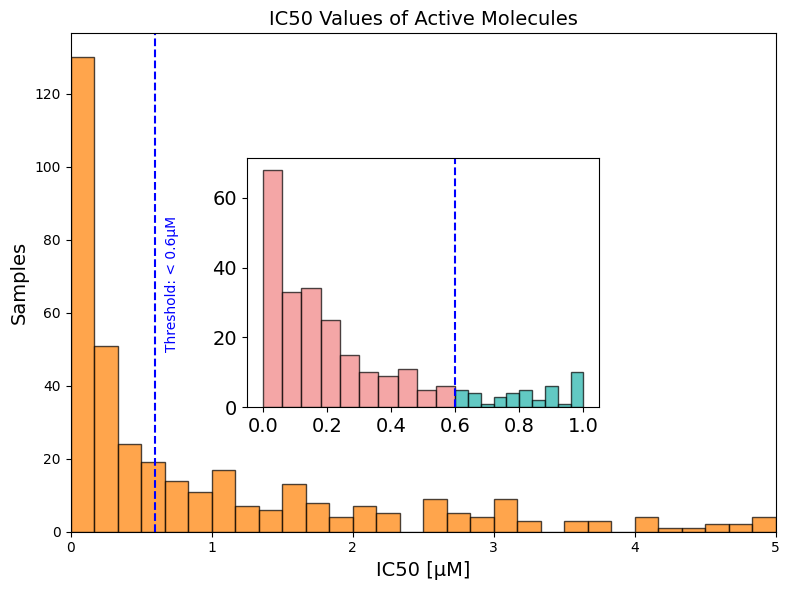

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Threshold value
threshold = 0.6

# Create main figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Main histogram
ax.hist(df_active_IC50_ranked['Value'].to_numpy(), bins=30, edgecolor='black', alpha=0.7, range=(0, 5), color='#FF7F00')
ax.set_xlabel('IC50 [µM]', fontsize = 14)
ax.set_ylabel('Samples', fontsize = 14)
ax.set_title('IC50 Values of Active Molecules', fontdict={'fontsize': 14})
ax.margins(x=0)
ax.axvline(x=threshold, color='blue', linestyle='--')
ax.text(0.67, 50, 'Threshold: < 0.6µM', color='blue', fontsize=10, rotation=90)
plt.grid(False)

# Create inset axis
ax_inset = inset_axes(ax, width="50%", height="50%", loc='center')

# Separate data into two groups based on threshold
data_left = df_active_IC50_ranked[df_active_IC50_ranked['Value'] < threshold]['Value']
data_right = df_active_IC50_ranked[df_active_IC50_ranked['Value'] >= threshold]['Value']

# Plot bars with different colors
ax_inset.hist(data_left, bins=10, edgecolor='black', alpha=0.7, range=(0, threshold), color='lightcoral')
ax_inset.hist(data_right, bins=10, edgecolor='black', alpha=0.7, range=(threshold, 1), color='lightseagreen')

# Add vertical line for threshold
ax_inset.axvline(x=threshold, color='blue', linestyle='--')

ax_inset.tick_params(axis='both', labelsize=14)
ax_inset.grid(False)

# Set inset title
# ax_inset.set_title('IC50: (0,1) µM', fontdict={'fontsize': 12, 'family': 'serif'})

# Save and show plot
plt.tight_layout()
plt.savefig("hs_ac_ic50.png", dpi=1400, bbox_inches='tight')
plt.show()


IC50 values below 1 are considered excellent binding affinities. Those molecules contain property values (descriptors or fingerprints) that are the easiest to train.

You can dive deeper by observing the frequency of certain values in the range (0, 1) and perhaps establish a threshold lower than 1 (in our case, <0.6 seemed plausible given the low frequency of molecules in the 0.7-1.0 range)

The same analysis can be applied to unspecified molecules with an emphasis on finding candidates for our training set that are likely to be inactive but not be so undrug-like that it causes our model to read irrelevant properties are determining factors of activity.

To achieve this, unspecified molecules in the range of IC50 values (10, 310) can be chosen. Molecules with an IC50 higher than 10 are likely to be inactive but those that are greater than 310 are likely to be overtly non-drug like and a bad source of learning

In [ ]:
df_unspecified_IC50 = df[df['Activity'] == "Unspecified"]
df_unspecified_IC50 = df_unspecified_IC50[df_unspecified_IC50["Value"] > 10]
df_unspecified_IC50 = df_unspecified_IC50[df_unspecified_IC50["Value"] < 350]
df_unspecified_IC50_ranked = df_unspecified_IC50.sort_values(by='Value')
df_unspecified_IC50_ranked.reset_index(drop=True, inplace=True)
df_unspecified_IC50_ranked

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,16094751,"(S)-quinolin-3-ylmethyl 2-((((S)-3-bromo-4,5-d...",Ki,11.0,Unspecified,=,O=C(NCC1CC(Br)=NO1)C1CCCN1C(=O)OCc1cnc2ccccc2c1
1,56954826,Benzyl 4-[3-fluoro-4-(prop-2-enoylamino)phenyl...,IC50,13.0,Unspecified,=,C=CC(=O)Nc1ccc(S(=O)(=O)N2CCN(C(=O)OCc3ccccc3)...
2,71459389,(2S)-2-(naphthalen-1-ylmethoxycarbonylamino)-6...,IC50,14.0,Unspecified,=,C=CC(=O)NCCCCC(NC(=O)OCc1cccc2ccccc12)C(=O)O
3,71455728,(2S)-2-[(4-methylphenyl)methoxycarbonylamino]-...,IC50,14.0,Unspecified,=,C=CC(=O)NCCCCC(NC(=O)OCc1ccc(C)cc1)C(=O)O
4,145987285,N-[(5S)-6-[4-(6-nitropyridin-3-yl)piperazin-1-...,Ki,15.0,Unspecified,=,CCC(=O)NCCCCC(NC(=O)Cc1ccccc1)C(=O)N1CCN(c2ccc...
...,...,...,...,...,...,...,...
70,72205083,(2S)-5-oxo-2-[[2-(phenylmethoxycarbonylamino)a...,IC50,200.0,Unspecified,>,Cc1c(C)[n+](C)c(SCC(=O)CCC(NC(=O)CNC(=O)OCc2cc...
71,7054,Isatin,IC50,250.0,Unspecified,>,O=C1Nc2ccccc2C1=O
72,3798517,"1-{4-[(2,3-Dioxo-2,3-dihydro-1H-indol-1-YL)met...",IC50,250.0,Unspecified,>,Cc1cc(CN2C(=O)C(=O)c3ccccc32)c(C)cc1CN1C(=O)C(...
73,6020915,(E)-3-(3-hydroxyphenyl)-1-pyridin-3-ylprop-2-e...,IC50,266.0,Unspecified,=,O=C(C=Cc1cccc(O)c1)c1cccnc1


Construct another histogram, this time graphing the frequency of certain IC50 values in the unspecified set.

Once again, the range can be adjusted using 'bins' to allow for more educated assumptions.

We can see that the bulk of unspecified values lies in the 20-100 range but those greater in the range (100, 300) still contain a fair share that are worth keeping in our dataset

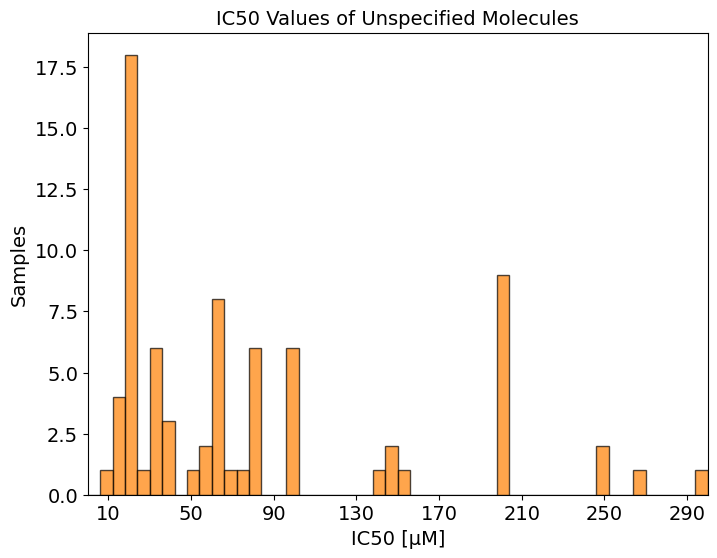

In [ ]:
plt.figure(figsize=(8, 6))
ic50_values2 = df_unspecified_IC50_ranked['Value'].to_numpy()
plt.hist(ic50_values2, bins=50, edgecolor='black', alpha=0.7, range = (0, max(ic50_values2)), color = '#FF7F00')
plt.xlabel('IC50 [µM]', fontsize = 14)
plt.ylabel('Samples', fontsize = 14)
plt.title('IC50 Values of Unspecified Molecules', fontdict={'fontsize': 14})
plt.margins(x=0)
plt.xticks([10, 50, 90, 130, 170, 210, 250, 290], fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig("hs_uns_ic50.png", dpi = 1400, bbox_inches='tight')
plt.show()

<ipython-input-17-7dff7988aa68>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


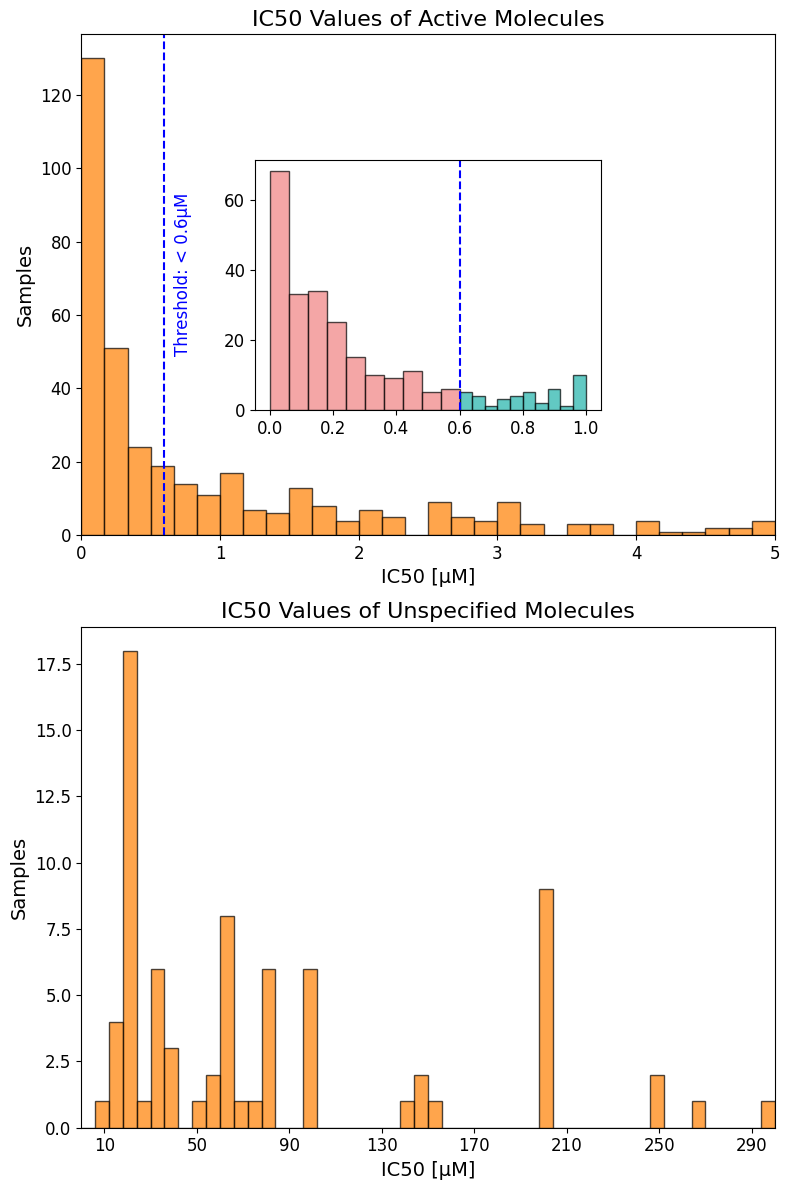

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Threshold value
threshold = 0.6

# Create a figure with two subplots vertically aligned
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Font size settings
font_size_title = 16
font_size_labels = 14
font_size_ticks = 12

# Main histogram for active molecules
ax1.hist(df_active_IC50_ranked['Value'].to_numpy(), bins=30, edgecolor='black', alpha=0.7, range=(0, 5), color='#FF7F00')
ax1.set_xlabel('IC50 [µM]', fontsize=font_size_labels)
ax1.set_ylabel('Samples', fontsize=font_size_labels)
ax1.set_title('IC50 Values of Active Molecules', fontsize=font_size_title)
ax1.margins(x=0)
ax1.axvline(x=threshold, color='blue', linestyle='--')
ax1.text(0.67, 50, 'Threshold: < 0.6µM', color='blue', fontsize=font_size_ticks, rotation=90)
ax1.tick_params(axis='x', labelsize=font_size_ticks)
ax1.tick_params(axis='y', labelsize=font_size_ticks)
ax1.grid(False)

# Create inset axis for active molecules
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='center')

# Separate data into two groups based on threshold
data_left = df_active_IC50_ranked[df_active_IC50_ranked['Value'] < threshold]['Value']
data_right = df_active_IC50_ranked[df_active_IC50_ranked['Value'] >= threshold]['Value']

# Plot bars with different colors in inset
ax_inset.hist(data_left, bins=10, edgecolor='black', alpha=0.7, range=(0, threshold), color='lightcoral')
ax_inset.hist(data_right, bins=10, edgecolor='black', alpha=0.7, range=(threshold, 1), color='lightseagreen')

# Add vertical line for threshold in inset
ax_inset.axvline(x=threshold, color='blue', linestyle='--')
ax_inset.tick_params(axis='both', labelsize=font_size_ticks)
ax_inset.grid(False)

# Histogram for unspecified molecules
ic50_values2 = df_unspecified_IC50_ranked['Value'].to_numpy()
ax2.hist(ic50_values2, bins=50, edgecolor='black', alpha=0.7, range=(0, max(ic50_values2)), color='#FF7F00')
ax2.set_xlabel('IC50 [µM]', fontsize=font_size_labels)
ax2.set_ylabel('Samples', fontsize=font_size_labels)
ax2.set_title('IC50 Values of Unspecified Molecules', fontsize=font_size_title)
ax2.margins(x=0)
ax2.set_xticks([10, 50, 90, 130, 170, 210, 250, 290])
ax2.tick_params(axis='x', labelsize=font_size_ticks)
ax2.tick_params(axis='y', labelsize=font_size_ticks)
ax2.grid(False)

# Save and show plot
plt.tight_layout()
plt.savefig("combined_ic50.png", dpi=1400, bbox_inches='tight')
plt.show()

The subsets can now be sliced to accomodate the ranges of IC50s we wish.

In [ ]:
df_active_IC50_ranked = df_active_IC50_ranked[df_active_IC50_ranked["Value"] < 0.6]
df_unspecified_IC50 = df_unspecified_IC50[df_unspecified_IC50["Value"] > 10]
df_unspecified_IC50_ranked = df_unspecified_IC50_ranked[df_unspecified_IC50_ranked["Value"] < 301]
print(len(df_active_IC50_ranked))
print(len(df_unspecified_IC50_ranked))

216
75


Note that the dataset is much more balanced now as a result of our statistical search.

When experimenting with a two class classficiation mode, it is best that one class take about 50-70% of the dataset to prevent bias.

In [ ]:
df_active2 = df_active_IC50_ranked
df_inactive2 = df[df['Activity'] == "Inactive"]
df_unspecified2 = df_unspecified_IC50_ranked
print("Active: " + str(len(df_active2)))
print("Inactive: " + str(len(df_inactive2)+len(df_unspecified2)))

Active: 216
Inactive: 120


Now it is time to create a master dataset with all the molecules that we wish our model to learn off of. Concatenate the dataframes of the active, inactive, and unspecified molecules and drop all columns except the SMILES, Activity, and any identfication purposed column

In [ ]:
df2 = pd.concat([df_active2, df_inactive2, df_unspecified2], ignore_index = True)
selected_columns = ['CID','Compound_Name', 'Smiles', 'Activity']
df2 = df2[selected_columns]
activity_list = []
for activity in df2["Activity"]:
  if activity == "Active":
    activity_list.append(1)
  elif activity == "Inactive" or activity == "Unspecified" or activity == "Inconclusive":
    activity_list.append(0)
df2["Activity Value"] = activity_list
df2

,CID,Compound_Name,Smiles,Activity,Activity Value
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1,Active,1
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...,Active,1
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...,Active,1
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...,Active,1
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...,Active,1
...,...,...,...,...,...
331,72205083,(2S)-5-oxo-2-[[2-(phenylmethoxycarbonylamino)a...,Cc1c(C)[n+](C)c(SCC(=O)CCC(NC(=O)CNC(=O)OCc2cc...,Unspecified,0
332,7054,Isatin,O=C1Nc2ccccc2C1=O,Unspecified,0
333,3798517,"1-{4-[(2,3-Dioxo-2,3-dihydro-1H-indol-1-YL)met...",Cc1cc(CN2C(=O)C(=O)c3ccccc32)c(C)cc1CN1C(=O)C(...,Unspecified,0
334,6020915,(E)-3-(3-hydroxyphenyl)-1-pyridin-3-ylprop-2-e...,O=C(C=Cc1cccc(O)c1)c1cccnc1,Unspecified,0


## Step 2: Getting Molecular Fingerprints & Descriptors

2.1: Generate rdkit fingerprints to serve as features that our model will learn off of

Molecular fingerprints are binary variables that indicate the presence of a certain functional group or substructure in a molecule. Because the bioactivity of a drug primarily depends on its properties, fingerprints are an excellent tool to aid our model in predicting the activity of molecules it has never seen before

Generate a visualized structure for each molecule using its SMILES. This will be used to calculate the actual fingerprints.

In [ ]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df2,'Smiles', 'Structure')

,CID,Compound_Name,Smiles,Activity,Activity Value,Structure
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1,Active,1,
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...,Active,1,
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...,Active,1,
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...,Active,1,
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...,Active,1,
...,...,...,...,...,...,...
331,72205083,(2S)-5-oxo-2-[[2-(phenylmethoxycarbonylamino)a...,Cc1c(C)[n+](C)c(SCC(=O)CCC(NC(=O)CNC(=O)OCc2cc...,Unspecified,0,
332,7054,Isatin,O=C1Nc2ccccc2C1=O,Unspecified,0,
333,3798517,"1-{4-[(2,3-Dioxo-2,3-dihydro-1H-indol-1-YL)met...",Cc1cc(CN2C(=O)C(=O)c3ccccc32)c(C)cc1CN1C(=O)C(...,Unspecified,0,
334,6020915,(E)-3-(3-hydroxyphenyl)-1-pyridin-3-ylprop-2-e...,O=C(C=Cc1cccc(O)c1)c1cccnc1,Unspecified,0,

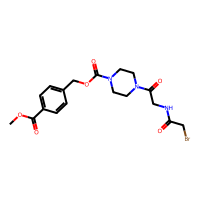
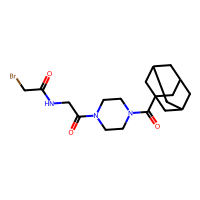
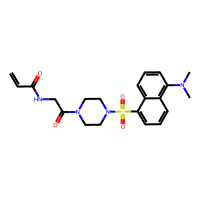
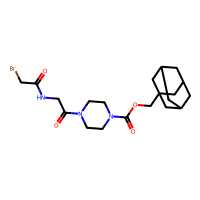
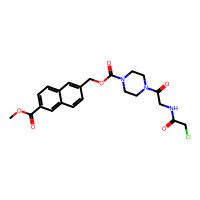
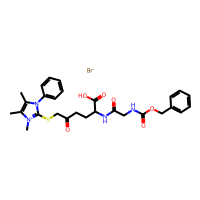
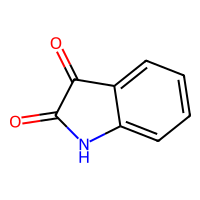
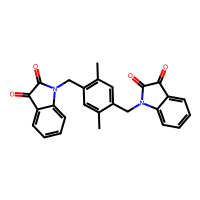
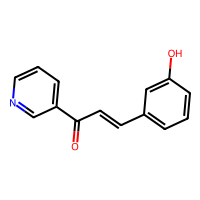
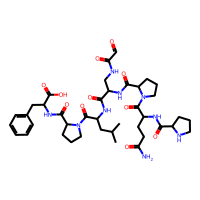

In [ ]:
df2

Import necessary fingerprint libaries and write a function that calculates all fingerprints and stores in a numpy array

In [ ]:
from rdkit.Chem.inchi import MolBlockToInchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
def generate_fpts(data):

    Rdk_fpts = []

    rdkbi_list= []

    onbit_list = []

    for smiles in data["Smiles"]:
        mol = Chem.MolFromSmiles(smiles)
        rdkbi = {}
        Rdk = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512, bitInfo=rdkbi)
        Rdk_fpts.append(Rdk)
        rdkbi_list.append(rdkbi)
        onbit_list.append(list(Rdk.GetOnBits())[:10])


    return pd.DataFrame(np.array(Rdk_fpts)), rdkbi_list, rdkbi, onbit_list

In [ ]:
df3, rdkbi_list, rdkbi, onbit_list = generate_fpts(df2)
df3 = pd.DataFrame(df3)
df3

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,1,1,0,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
4,0,1,1,0,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1,0,1,1,0,1,1,1,1,1,...,0,1,0,0,1,1,1,1,1,1
332,0,1,1,0,1,1,0,1,0,1,...,0,0,0,0,1,1,1,0,0,1
333,0,1,1,0,1,1,0,1,0,1,...,0,0,0,1,1,1,1,0,0,1
334,1,1,1,1,0,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,1


Call the fingerprint generation function and convert to a dataframe

You will now be able to observe the binary values of the fingerprints. A "1" indicates the presence of a certain substructure while "0" indicates the absence

2.2: Remove correlated and low_variance fingerprint features

Although each fingerprint may represent a distinct substructure, the presence of a fingerprint may be dependent on the presence of another indicating that the dependent fingerprint is simply an unncessary extra parameter for our model to learn off of. These can be removed by writing a quick function that deletes highly correlated features.

That is not to say that correlation is not important when discussing bioactivity but the most important relationships in feature analysis are between INDEPENDENT features that are moderately related and contribute in combination with each other towards activity rather than directly affect each other.

Fingerprints can also be classified as "low variance" if its presence or absence is fairly prominent throughout the set indicating that it is not a distinguishable factor. These can also be removed.

In [ ]:
def remove_correlated_features(descriptors):

    correlated_matrix = descriptors.corr().abs()


    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(bool))


    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped, to_drop

fingerprints_new, to_drop = remove_correlated_features(df3)
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    selected_indices = selection.get_support(indices=True)
    removed_indices = [i for i in range(input_data.shape[1]) if i not in selected_indices]
    return input_data[input_data.columns[selection.get_support(indices=True)]], removed_indices

df5, removed_indices = remove_low_variance(fingerprints_new, threshold=0.1)
df5

,0,1,4,5,6,7,8,9,10,11,...,499,500,501,502,503,504,505,507,509,510
0,0,1,0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1,0,0,1,1,1,1,1,0,1,...,1,1,1,0,1,0,0,1,1,1
332,0,1,1,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
333,0,1,1,1,0,1,0,1,1,1,...,0,0,1,0,0,0,1,1,0,0
334,1,1,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
all_drops = to_drop + removed_indices
all_drops

[330,
 342,
 2,
 3,
 16,
 36,
 40,
 51,
 64,
 81,
 87,
 103,
 112,
 117,
 141,
 142,
 161,
 166,
 186,
 194,
 209,
 233,
 236,
 238,
 248,
 265,
 280,
 284,
 290,
 294,
 297,
 312,
 341,
 351,
 369,
 371,
 372,
 379,
 386,
 402,
 403,
 410,
 416,
 417,
 428,
 439,
 443,
 447,
 460,
 479,
 480,
 491,
 504,
 506,
 509]

2.3: Get Molecular Desciptors for all molecules

In [ ]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            import traceback
            traceback.print_exc()
            val = missingVal
        res[nm] = val
    return res

mols_desc = [Chem.MolFromSmiles(molecule) for molecule in df2["Smiles"]]
allDescrs = [getMolDescriptors(molecule) for molecule in mols_desc]
print(allDescrs[0])
df10 = pd.DataFrame(allDescrs)
df10

[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerator
[15:00:05] DEPRECATION WARNING: please use MorganGenerat

{'MaxAbsEStateIndex': 12.187247039860226, 'MaxEStateIndex': 12.187247039860226, 'MinAbsEStateIndex': 0.059078166969260604, 'MinEStateIndex': -0.46135650746626555, 'qed': 0.5009871551522316, 'SPS': 13.642857142857142, 'MolWt': 456.2930000000002, 'HeavyAtomMolWt': 434.11700000000013, 'ExactMolWt': 455.069197524, 'NumValenceElectrons': 152, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.40971665780762734, 'MinPartialCharge': -0.4654175212303123, 'MaxAbsPartialCharge': 0.4654175212303123, 'MinAbsPartialCharge': 0.40971665780762734, 'FpDensityMorgan1': 1.0357142857142858, 'FpDensityMorgan2': 1.6428571428571428, 'FpDensityMorgan3': 2.2142857142857144, 'BCUT2D_MWHI': 79.91872991762592, 'BCUT2D_MWLOW': 10.139163581336364, 'BCUT2D_CHGHI': 2.2464711944419657, 'BCUT2D_CHGLO': -2.3370933616243823, 'BCUT2D_LOGPHI': 2.0936473398296145, 'BCUT2D_LOGPLOW': -2.5230923998448294, 'BCUT2D_MRHI': 9.09156816604207, 'BCUT2D_MRLOW': -0.13328161934241156, 'AvgIpc': 2.7486081400064735, 'BalabanJ': 1.73556134618

[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator
[15:00:16] DEPRECATION WARNING: please use MorganGenerator


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.187247,12.187247,0.059078,-0.461357,0.500987,13.642857,456.293,434.117,455.069198,152,...,0,0,0,0,0,0,0,0,0,0
1,13.342388,13.342388,0.035077,-0.186130,0.691205,35.500000,426.355,398.131,425.131404,144,...,0,0,0,0,0,0,0,0,0,0
2,13.353565,13.353565,0.130716,-3.716049,0.691985,15.066667,430.530,404.322,430.167476,160,...,0,1,0,0,0,0,0,0,0,0
3,12.559640,12.559640,0.000893,-0.240337,0.642382,33.678571,456.381,426.141,455.141969,156,...,0,0,0,0,0,0,0,0,0,0
4,12.395315,12.395315,0.108263,-0.450298,0.518853,13.562500,461.902,437.710,461.135363,170,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,12.665429,12.665429,0.000000,-1.261695,0.176601,11.175000,633.565,600.301,632.130418,214,...,1,0,0,0,0,0,0,0,0,0
332,10.984491,10.984491,0.443889,-0.535926,0.552029,14.545455,147.133,142.093,147.032028,54,...,0,0,0,0,0,0,0,0,0,0
333,12.543963,12.543963,0.290183,-0.523044,0.597933,14.937500,424.456,404.296,424.142307,158,...,0,0,0,0,0,0,0,0,0,0
334,11.713616,11.713616,0.109775,-0.109775,0.645011,10.588235,225.247,214.159,225.078979,84,...,0,0,0,0,0,0,0,0,0,0


Concatenate fingerprints, descriptors and molecules and drop all columns that are not features or the class.

We now have our final dataset that we will train our classification models on!

In [ ]:
df4 = pd.concat([df5, df10, df2], axis=1)
# df4 = pd.concat([df3, df2], axis=1)
df4.drop(['Activity', 'Compound_Name', 'CID', 'Smiles', 'Structure'], axis = 1, inplace = True)
df4

,0,1,4,5,6,7,8,9,10,11,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Activity Value
0,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1,0,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
332,0,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
333,0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
334,1,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df245 = result = pd.concat([df2, df4], axis=1)
df245.drop(['CID', 'Structure', 'Activity Value', 'Structure'], inplace = True, axis = 1)
df245.to_csv('TG2_classfication_train_test.csv')

In [ ]:
df4 = pd.read_csv("TG2_cleaned_descriptors_fingerprints_classification.csv")

## Step 3: Training Classification Models on Dataset

3.1: Perform preliminary procedures for training

Split dataset into training and testing set, make sure to set stratify = y to keep ratio constant in training and testing sets

In [ ]:
X = df4.iloc[:, :-1].values
y = df4.iloc[:, -1].values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 1) # stratify keeps ratio constant

In [ ]:
active_count1 = 0
for x in y_train:
  if x == 1:
    active_count1+=1
active_count2 = 0
for x in y_test:
  if x == 1:
    active_count2+=1
print(len(y_train))
print(len(y_test))
print(active_count1)
print(active_count2)
print(active_count1/len(y_train))
print(active_count2/len(y_test))

252
84
162
54
0.6428571428571429
0.6428571428571429


Perform feature scaling to prevent the dominance of a single feature

Note that if we only had fingerprints, feature scaling would not affect our dataset at the because it is completely binary but we do have descriptors which contain some values that are on a totally different scale from fingerprints. We will only standard scale descriptors.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train[:1]

array([[-0.88014083, -1.46628783, -1.        , -1.34164079, -1.30754634,
        -0.6017991 ,  0.99209474,  0.38818157, -0.77787887,  1.0405021 ,
        -0.47254732,  1.41421356,  0.58345997,  0.75180941,  0.38138504,
        -0.73251987, -1.03226633, -0.92354815,  1.11803399, -0.54065487,
         0.52223297, -0.91619652, -0.93094934, -1.27475488,  0.45993311,
        -0.60791876, -0.44080925, -0.75828754, -0.44080925, -1.80864215,
         0.8660254 , -0.88014083,  0.56512983,  1.07417231,  0.65094455,
        -0.38138504,  0.36760731, -0.47881969,  1.45296631, -0.75828754,
        -0.5956834 ,  0.47254732,  1.50755672,  0.96874225,  0.67575691,
         0.60791876,  1.22272217, -0.64477154, -0.75180941, -0.70710678,
         1.1361818 , -0.63860882, -1.14539365,  1.17360917, -0.67575691,
         0.55290097, -0.8660254 , -0.6017991 , -0.35355339,  0.75180941,
        -0.66953406,  0.52223297, -0.82462113, -1.64495664, -0.80439967,
        -0.74535599, -0.68199434, -1.82888698,  0.8

3.2: Use lazypredict to find the best classification model for our dataset

Lazypredict is a package that can train tens of different models on our dataset and provide us the ones with the best performance scores

In [ ]:
# Install lazypredict if not already installed
!pip install lazypredict

# Import necessary packages
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import precision_score, matthews_corrcoef
import pandas as pd

# Assuming X_train, X_test, y_train, y_test are already defined

# Fit the LazyClassifier
lcls = LazyClassifier(verbose=0, ignore_warnings=True)
models, prediction_tests = lcls.fit(X_train, X_test, y_train, y_test)

# Initialize lists to store precision and MCC scores
precision_scores = []
mcc_scores = []

# Get the model names and corresponding models
model_names = models.index

# Loop through the classifiers to calculate precision and MCC
for name in model_names:
    model = lcls.models[name]  # Access the actual model object from lcls.models

    # Predict using the model
    y_pred = model.predict(X_test)

    # Calculate precision and MCC
    precision = precision_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)

    # Append the scores to the respective lists
    precision_scores.append(precision)
    mcc_scores.append(mcc)

# Add the custom metrics to the prediction_tests DataFrame
prediction_tests['Precision'] = precision_scores
prediction_tests['MCC'] = mcc_scores

# Display the results
print(prediction_tests)




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
 97%|█████████▋| 28/29 [00:06<00:00,  2.30it/s]

[LightGBM] [Info] Number of positive: 162, number of negative: 90
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7837
[LightGBM] [Info] Number of data points in the train set: 252, number of used features: 613
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642857 -> initscore=0.587787
[LightGBM] [Info] Start training from score 0.587787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.96               0.96     0.96      0.96   
LGBMClassifier                     0.95               0.95     0.95      0.95   
LogisticRegression                 0.95               0.94     0.94      0.95   
ExtraTreesClassifier               0.94               0.94     0.94      0.94   
CalibratedClassifierCV             0.94               0.93     0.93      0.94   
XGBClassifier                      0.94               0.93     0.93      0.94   
RandomForestClassifier             0.94               0.93     0.93      0.94   
PassiveAggressiveClassifier        0.94               0.93     0.93      0.94   
RidgeClassifierCV                  0.94               0.92     0.92      0.94   
ExtraTreeClassifier                0.94               0.92     0.92      0.94   
RidgeClassifier             

Reproduce the results of the lazy classifier to verify its results

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
etc2 = AdaBoostClassifier()
etc2.fit(X_train, y_train)
etc_pred2 = etc2.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
etc_cm2 = confusion_matrix(y_test, etc_pred2)
print(etc_cm2)
accuracy_score(y_test, etc_pred2)

[[28  2]
 [ 1 53]]


0.9642857142857143

Run a Dummy Classifier to establish the baseline

In [ ]:
dcl = DummyClassifier()
dcl.fit(X_train, y_train)
dcl_pred = dcl.predict(X_test)

dcl_cm = confusion_matrix(y_test, dcl_pred)
print(dcl_cm)
accuracy_score(y_test, dcl_pred)

[[ 0 30]
 [ 0 54]]


0.6428571428571429

We can optimize the AdaBoost using bayesian optimization based optuna which experiments with many hyperparameters including a base estimator and its own various attributes to decide what parameters are needed to ensure a maximum accuracy. Optimization by this method contains a process that involves random sampling so each optimization run may not yield the same exact results but should give you an idea of what range of parameters are optimal. Cross validation is similar in that sense (it attempts to conduct random sampling of training and testing)


Uncomment the code below to run a sample optimzing test. Once you formulate your best models, you will likely not need them and commenting them out will increase the speed of the notebook run.

When running a cross validation on one model, commenting out the other code in this section is recommended unless starting exactly from the cv cell.

In [ ]:
# !pip install optuna
# import optuna

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import Perceptron, LogisticRegression
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1.0)
#     base_estimator = trial.suggest_categorical('base_estimator', ['DecisionTreeClassifier','RandomForestClassifier'])
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

#     if base_estimator == 'DecisionTreeClassifier':
#         from sklearn.tree import DecisionTreeClassifier
#         base_estimator = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
#     elif base_estimator == 'RandomForestClassifier':
#         from sklearn.ensemble import RandomForestClassifier
#         base_estimator = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split)


#     model = AdaBoostClassifier(
#         base_estimator=base_estimator,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         random_state = 42
#     )

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     # pipeline = make_pipeline(StandardScaler(), model)
#     # cv_scores = cross_val_score(pipeline, X, y, cv=kf2)

#     # return np.mean(cv_scores)
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Best trial:')
# best_trial = study.best_trial
# print(f'  Value: {best_trial.value}')
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print(f'    {key}: {value}')

In [ ]:
# import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.neural_network import MLPClassifier

class CustomMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=int)  # Change np.int to int
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)

        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))



# def objective(trial):
#     # Define the search space for hyperparameters of the weak neural network
#     hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 1, 100)
#     activation = trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu'])
#     learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-1)

#     # Instantiate the weak neural network model
#     model = CustomMLPClassifier(
#         hidden_layer_sizes=(hidden_layer_sizes,),
#         activation=activation,
#         learning_rate_init=learning_rate_init,
#         max_iter=1000
#     )

#     # Train the model
#     model.fit(X_train, y_train, sample_weight=None)  # No need for sample_weight in initial MLPClassifier training

#     # Evaluate the model
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

# def optimize_adaboost(trial):
#     # Define the search space for AdaBoost hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1)

#     # Instantiate the AdaBoost model with the weak neural network as base estimator
#     base_estimator = CustomMLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate_init=0.001, max_iter=1000)
#     ada_boost_model = AdaBoostClassifier(
#         base_estimator=base_estimator,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         random_state=42
#     )

#     # Train the AdaBoost model
#     ada_boost_model.fit(X_train, y_train)  # No need for sample_weight in AdaBoostClassifier

#     # Evaluate the AdaBoost model
#     y_pred = ada_boost_model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

# if __name__ == "__main__":


#     # Create an Optuna study for tuning the weak neural network
#     study_nn = optuna.create_study(direction='maximize')
#     study_nn.optimize(objective, n_trials=50)

#     # Create an Optuna study for tuning AdaBoost with the weak neural network as base estimator
#     study_adaboost = optuna.create_study(direction='maximize')
#     study_adaboost.optimize(optimize_adaboost, n_trials=50)

#     print("Best weak neural network hyperparameters: ", study_nn.best_params)
#     print("Best AdaBoost hyperparameters: ", study_adaboost.best_params)

#     # Plotting the contour plot for AdaBoost hyperparameters


In [ ]:
# vis.plot_contour(study_adaboost, params=['n_estimators', 'learning_rate'])
# plt.title('AdaBoost Hyperparameters')
# plt.show()

In [ ]:
# best_n_estimators = study.best_params['n_estimators']
# best_learning_rate = study.best_params['learning_rate']
# best_base_estimator = study.best_params['base_estimator']
# best_max_depth = study.best_params['max_depth']
# best_min_samples_split = study.best_params['min_samples_split']

# print("\nBest Parameters:")
# print(f"  n_estimators: {best_n_estimators}")
# print(f"  learning_rate: {best_learning_rate}")
# print(f"  base_estimator: {best_base_estimator}")
# print(f"  max_depth: {best_max_depth}")
# print(f"  min_samples_split: {best_min_samples_split}")

In [ ]:
# import optuna.visualization.matplotlib as optuna_plt
# optuna.visualization.matplotlib.plot_optimization_history(study)
# plt.show()

In [ ]:
# ax = optuna.visualization.matplotlib.plot_contour(study, params=["n_estimators", "learning_rate",])
# ax.set_title('Estimator & Learning Rate Tuning', fontsize=12, fontweight = 'bold')
# ax.scatter(best_learning_rate, best_n_estimators, color='red', label=f'\n n_estimators = {best_n_estimators}    learning_rate = {best_learning_rate:.6f}', s = 60)
# plt.legend(loc = 3)
# plt.savefig('adaboost_contour_map1.png', dpi=1400, bbox_inches='tight')
# plt.show()

In [ ]:
# ax2 = optuna.visualization.matplotlib.plot_contour(study, params=["min_samples_split", "max_depth",])
# ax2.set_title('Sample Split & Depth Tuning', fontsize=12, fontweight = 'bold')
# ax2.scatter(best_max_depth, best_min_samples_split, color='red', label=f'\n min_samples_split = {best_min_samples_split}      max_depth = {best_max_depth}', s = 60)
# plt.legend(loc = 3)
# plt.savefig('adaboost_contour_map2.png', dpi=1400, bbox_inches='tight')
# plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pickle
etc = AdaBoostClassifier(n_estimators = 442,learning_rate = 0.9960385753333603, base_estimator = RandomForestClassifier(max_depth=3, min_samples_split=3), random_state = 42)
etc.fit(X_train, y_train)
pickle.dump(etc, open('CLF_ada_rf.pkl', 'wb'))
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

kf2 = StratifiedKFold(n_splits=5, shuffle=True)
model_pipeline2 = make_pipeline(StandardScaler(), etc)

metrics_dict2 = {
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'Accuracy': make_scorer(accuracy_score),
    'AUC-ROC': make_scorer(roc_auc_score)
}

all_trials_scores2 = {metric: [] for metric in metrics_dict2}

for i in range(50):
    scores2 = cross_validate(model_pipeline2, X, y, cv=kf2, scoring=metrics_dict2)

    for metric in metrics_dict2:
        all_trials_scores2[metric].append(scores2[f'test_{metric}'].mean())
        print(scores2[f'test_{metric}'].mean())

for metric in metrics_dict2:
    std_dev = np.std(all_trials_scores2[metric])
    print(f'Standard Deviation of {metric}: {std_dev}')

etc.fit(X_train, y_train)
etc_pred = etc.predict(X_test)
etc_cm = confusion_matrix(y_test, etc_pred)
print(etc_cm)
accuracy_score(y_test, etc_pred)

0.8985309135309135
0.9581395348837208
0.926347513203497
0.9018437225636523
0.8790697674418604
0.8873695652173913
0.9767441860465116
0.92969313072375
0.9046532045654082
0.8758720930232557
Standard Deviation of Precision: 0.005580674156761112
Standard Deviation of Recall: 0.009302325581395376
Standard Deviation of F1 Score: 0.001672808760126543
Standard Deviation of Accuracy: 0.0014047410008779515
Standard Deviation of AUC-ROC: 0.0015988372093023173
[[25  5]
 [ 2 52]]


0.9166666666666666

In [ ]:
average_scores2 = {metric: np.mean(all_trials_scores2[metric]) for metric in metrics_dict2}
average_scores2

{'Precision': 0.8929502393741524,
 'Recall': 0.9674418604651163,
 'F1 Score': 0.9280203219636235,
 'Accuracy': 0.9032484635645303,
 'AUC-ROC': 0.8774709302325581}

In [ ]:
base_estimator = CustomMLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate_init=0.001, max_iter=1000)

# Instantiate the AdaBoost model with the given base estimator
etc2 = AdaBoostClassifier(
        base_estimator=base_estimator,
        n_estimators=279,
        learning_rate=0.022977463078217686,
        random_state=42
)

3.3: Perform cross validation to obtain an average accuracy your models

We must now evluate the overall reliability of our model by trying out new combinations of training and testing sets from our original dataset. Sklearn's KFold cross validation is a great tool to do this.

To ensure that every split has the same active to inactive ratio, we perform a Stratrified KFold with 5 splits.

We can do this a number of times (we did 100) and obtain an average accuracy.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
kf = StratifiedKFold(n_splits=5, shuffle=True)
model_pipeline = make_pipeline(StandardScaler(), etc2)

metrics_dict = {
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'Accuracy': make_scorer(accuracy_score),
    'AUC-ROC': make_scorer(roc_auc_score)
}

all_trials_scores = {metric: [] for metric in metrics_dict}

for i in range(2):
    scores = cross_validate(model_pipeline, X, y, cv=kf, scoring=metrics_dict)

    for metric in metrics_dict:
        all_trials_scores[metric].append(scores[f'test_{metric}'].mean())
        print(i)
        print(scores[f'test_{metric}'].mean())

for metric in metrics_dict:
    std_dev = np.std(all_trials_scores2[metric])
    print(f'Standard Deviation of {metric}: {std_dev}')



0
0.9282795724260346
0
0.9535940803382663
0
0.9405108024670268
0
0.9226075504828797
0
0.9101303735024665


In [ ]:
average_scores = {metric: np.mean(all_trials_scores[metric]) for metric in metrics_dict}
average_scores

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

table_data = [[key, f'{value:.2f}'] for key, value in average_scores.items()]

table = ax.table(cellText=table_data,colLabels=["Metric", "Average"], loc='center', cellLoc='center', colColours=['#c4e5ff']*2)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.45, 2)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_linewidth(1.2)
        cell.set_edgecolor('black')
        cell.set_text_props(weight='bold')
    else:
        cell.set_linewidth(0.8)
        cell.set_edgecolor('black')
    cell.set_facecolor('#c4e5ff')

ax.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for metric in metrics_dict:
    sn.lineplot(x=range(1, 11), y=all_trials_scores[metric], label=metric)

plt.title('QBBAB Stratified 5-Fold Cross Validation Performance Metrics Over 100 Trials', fontweight = 'bold')
plt.xlabel('Trial')
plt.ylabel('Score')
plt.legend()
plt.savefig('long_perf.png', dpi = 1400)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
ax = sn.boxplot(data=pd.DataFrame(all_trials_scores))

for i, metric in enumerate(metrics_dict.keys()):
    avg_score = average_scores[metric]

ax.tick_params(axis='x', labelsize=11)

plt.figure(figsize=(15, 6))
plt.savefig('box_adaboost.png', dpi = 1400)
plt.show()

It seems that our model has an average accuracy of about 91-92%.

It is important to check whether this is reasonably close to the accuracy we obtained from the one split trained lazy classifier.

We can also perform sample prediction s using our model. The model must be fed with a smiles input to do this. We can predict the activity of inconclusive molecules.

In [ ]:
# etc.fit(X_train, y_train)
# print(accuracy_score(y_test, etc.predict(X_test)))

# active_preds = 0
# inactive_preds = 0
# for i, smiles in enumerate(df_inconclusive["Smiles"].head(20)):
#   a_sample_smiles = smiles
#   mol_samp = Chem.MolFromSmiles(a_sample_smiles)
#   canon_smiles = Chem.MolToSmiles(mol_samp)
#   mol = Chem.MolFromSmiles(canon_smiles)

#   rdkbi_input = {}
#   fingerprints_input = pd.DataFrame(np.array(AllChem.RDKFingerprint(mol_samp, maxPath=5, fpSize=512, bitInfo=rdkbi_input)))
#   fingerprints_input.drop(all_drops, inplace = True)
#   descriptors_input = getMolDescriptors(mol_samp)
#   desc_df = pd.DataFrame({'Values': pd.Series(list(descriptors_input.values()))})
#   desc_input = np.array(desc_df)
#   fing_input = np.array(fingerprints_input)
#   desc_input = desc_input.reshape((1, 210))
#   fing_input = fing_input.reshape(1, 457)
#   features = np.concatenate([fing_input, desc_input], axis=1)
#   features = sc.transform(features)
#   prediction = etc.predict(features)
#   if prediction == [0]:
#     inactive_preds += 1
#   if prediction == [1]:
#     active_preds +=1
#   print("CID: " + str(df_inconclusive["CID"].iloc[i]) + " Smiles: " + str(smiles) + " Prediction: " + str(prediction))
# print("\nTotal Inconclusives: " + str(len(df_inconclusive["Smiles"])))
# print("Inactive Predictions: " + str(inactive_preds))
# print("Active Predictions " + str(active_preds))

## Step 4: Feature Importance Analysis

4.1: Choose the feature importance model and look for common substructures

An important part of drug design is identifying certain substructures or functional groups that could be responsile for a molecule's bioactivity against a target.

If you remember, the parameters we used to train the model were molecular fingerprints which are binary values that indicate the presence of a certain type of component of a molecule (1 being present, 0 being not present)

Some classifiers have the capability of being able to identify the most important features that exert the highest influence on the classification of a datapoint. This is called feature importance.

Unforunately, our best classifier, AdaBoostClassifier does not have the capability to conduct feature importance. However, one classifier that also performed quite well was the Random Forest Classifier and it is an excellent model for feature importance extraction. Not all classifiers have the feature importance attribute so you will need to choose the best performing model from the lazy classifier that is compatible.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 0)
clf.fit(X, y)
feature_importance = clf.feature_importances_
feature_names = list(df5.columns)
print(len(feature_importance))
feature_importance

667


array([7.12313437e-04, 4.62849724e-03, 0.00000000e+00, 2.38003376e-05,
       4.37716045e-04, 1.92512666e-03, 1.72208341e-04, 0.00000000e+00,
       9.76285961e-05, 1.82254026e-04, 6.43480925e-05, 1.42502920e-03,
       2.31885606e-03, 2.95033487e-03, 2.16996534e-04, 0.00000000e+00,
       1.41500857e-03, 3.84921560e-04, 5.96082554e-04, 5.35855678e-04,
       1.06024802e-03, 4.37537549e-04, 1.66233766e-04, 1.21874264e-03,
       2.44201315e-04, 0.00000000e+00, 2.04724076e-03, 2.41861878e-04,
       3.53223693e-04, 4.66502159e-03, 4.07224144e-04, 0.00000000e+00,
       4.56200867e-04, 1.36091725e-04, 3.93396558e-05, 0.00000000e+00,
       5.73721882e-04, 1.13313448e-03, 1.17184088e-03, 0.00000000e+00,
       4.65795789e-04, 2.25723950e-04, 3.16467619e-05, 6.73178197e-04,
       3.09677419e-04, 9.84166167e-04, 9.30988621e-05, 2.59909393e-03,
       2.14348093e-04, 8.82166488e-04, 2.47613854e-04, 7.37117020e-04,
       2.22689494e-04, 6.20039835e-04, 6.00153513e-04, 3.03271862e-04,
      

We can print the 10 index numbers with the highest importance overall, the 10 indices of highest fingerprints, and the 10 indices of highest descriptors.

In [ ]:
indices_descending_all = np.argsort(feature_importance)[::-1]
indices_descending_fing = np.argsort(feature_importance[:458])[::-1]
indices_descending_desc = np.argsort(feature_importance[458:667])[::-1]
top_indices_all = indices_descending_all[:10]
top_indices_fing = indices_descending_fing[:10]
top_indices_desc = indices_descending_desc[:10]
top_indices_desc = [(x+458) for x in top_indices_desc]
print("Highest Overall Features: " + str(top_indices_all))
print("Highest Fingerprints: " + str(top_indices_fing))
print("Highest Descriptors: " + str(top_indices_desc))

Highest Overall Features: [577 578 443 524 555 388 477 532 344 478]
Highest Fingerprints: [443 388 344 307 317 176  67 375 240 279]
Highest Descriptors: [577, 578, 524, 555, 477, 532, 478, 507, 481, 516]


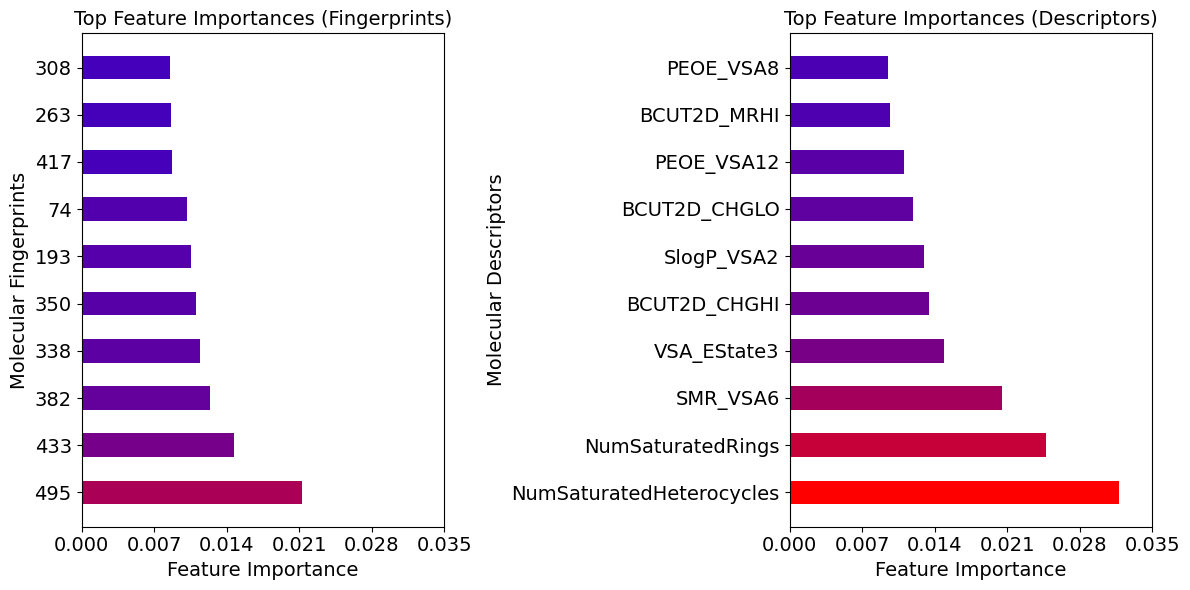

In [ ]:
selected_importance_fing = feature_importance[top_indices_fing]
selected_importance_desc = feature_importance[top_indices_desc]

max_value = max(max(selected_importance_fing), max(selected_importance_desc))

# Round the x-ticks to the nearest thousandth
rounded_ticks = np.around(np.linspace(0, max_value+0.003, num=6), decimals=3)

# Define a color gradient
def color_gradient(value):
    normalized_value = value / max_value  # Normalize the value
    # Define the color gradient (from blue to orange)
    return (normalized_value, 0, 1 - normalized_value)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for top indices related to "fing"
plt.subplot(1, 2, 1)
for i, (value, label) in enumerate(zip(selected_importance_fing, df4.columns[top_indices_fing])):
    plt.barh(label, value, 0.5, align='center', color=color_gradient(value))
plt.yticks(df4.columns[top_indices_fing], fontsize=14)
plt.xticks(rounded_ticks, fontsize=14)
plt.ylabel('Molecular Fingerprints', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Top Feature Importances (Fingerprints)', fontsize=14)
plt.tight_layout()

# Plot for top indices related to "desc"
plt.subplot(1, 2, 2)
for i, (value, label) in enumerate(zip(selected_importance_desc, df4.columns[top_indices_desc])):
    plt.barh(label, value, 0.5, align='center', color=color_gradient(value))
plt.yticks(df4.columns[top_indices_desc], fontsize=14)
plt.xticks(rounded_ticks, fontsize=14)
plt.ylabel('Molecular Descriptors', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Top Feature Importances (Descriptors)', fontsize= 14)

plt.tight_layout()
plt.savefig("need_feature_imp.png", dpi = 1400)
plt.show()

To find top fingerprints, we must find the fingerprint numbers associated with each important indice. Below we can see that indice 443 corresponds to fingerprint 495. This is because we removed fingerprints.

In [ ]:
important_fing_nums = [df4.columns[x] for x in top_indices_fing]
important_fing_nums

['495', '433', '382', '338', '350', '193', '74', '417', '263', '308']

4.2: Analyze the fingerprints of highest importance in our molecules

We can start out by simply visualizing the full structures of our molecules.

This will simply allow us to look for expected similarities. When working with much smaller molecules this would be much easier but because ours are much more complex, we will need to zoom into these molecules and find those fingerprints.

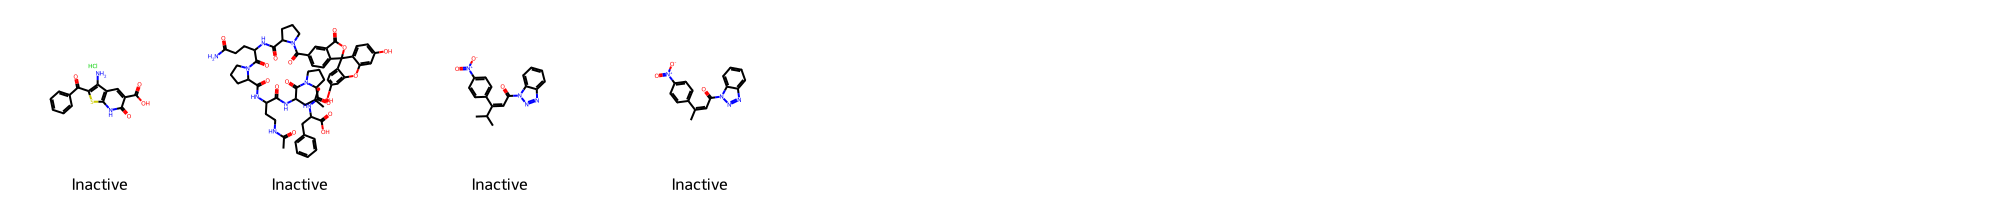

In [ ]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x for x in df2["Structure"][[216, 219, 224, 227]]], maxMols=100,
                     legends=[str(x) for x in df2.Activity[[216, 219, 224, 227]]], subImgSize=(200,200), molsPerRow=10)

In [ ]:
from PIL import Image
import tempfile

def set_image_dpi(image):
    """
    Rescaling image to 300dpi without resizing
    :param image: An image
    :return: A rescaled image
    """
    image_resize = image
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_filename = "mol3.png"
    image_resize.save(temp_filename, dpi=(300, 300))
    return temp_filename

# mol_image = Draw.MolToImage(Chem.MolFromSmiles(df2["Smiles"][239]))
# mol_image.show()
# mol_image.save("test.png")
# print(df2["Compound_Name"][8])
# print(df2["Compound_Name"][239])
for i, x in enumerate(df2["Compound_Name"]):
  if x == "N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfonyl]piperazin-1-yl]-2-oxo-ethyl]prop-2-enamide (3h)":
    y = i
    break
print(y)
img = Draw.MolToImage(Chem.MolFromSmiles(df2["Smiles"][239]))
img = set_image_dpi(img)
df2.head()

2


,CID,Compound_Name,Smiles,Activity,Activity Value,Structure
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7aba7d4ad230>
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7aba7d4ad380>
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7aba7d4adfc0>
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7aba7d4ade70>
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7aba7d4ae030>


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
!pip install cairosvg
import cairosvg
import io


def molecule_to_pdf(mol, file_name, width=300, height=300):
    """Save substance structure as PDF"""

    # Define full path name
    full_path = f"mol7.pdf"

    # Render high resolution molecule
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()

    # Export to pdf
    cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=full_path)

# Example
m = Chem.MolFromSmiles(df2["Smiles"][221])
molecule_to_pdf(m, "myfav")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
img = Draw.DrawRDKitBit(df2["Structure"][2],193,rdkbi_list[2])
img.save('fing_need_now.tiff', format='TIFF', dpi=(600, 600))

In [ ]:
fings_1 = []
fings_2 = []
fings_3 = []
fings_4 = []
fings_5 = []
fings_6 = []
fings_7 = []
fings_8 = []
fings_9 = []

for num, structure in enumerate(df2["Structure"]):
  if 495 in rdkbi_list[num]:
    fings_1.append(Draw.DrawRDKitBit(structure,495,rdkbi_list[num]))
  else:
    fings_1.append(None)
  if 433 in rdkbi_list[num]:
    fings_2.append(Draw.DrawRDKitBit(structure,433,rdkbi_list[num]))
  else:
    fings_2.append(None)
  if 382 in rdkbi_list[num]:
    fings_3.append(Draw.DrawRDKitBit(structure,382,rdkbi_list[num]))
  else:
    fings_3.append(None)
  if 338 in rdkbi_list[num]:
    fings_4.append(Draw.DrawRDKitBit(structure,338,rdkbi_list[num]))
  else:
    fings_4.append(None)
  if 350 in rdkbi_list[num]:
    fings_5.append(Draw.DrawRDKitBit(structure,350,rdkbi_list[num]))
  else:
    fings_5.append(None)
  if 193 in rdkbi_list[num]:
    fings_6.append(Draw.DrawRDKitBit(structure,193,rdkbi_list[num]))
  else:
    fings_6.append(None)
  if 74 in rdkbi_list[num]:
    fings_7.append(Draw.DrawRDKitBit(structure,74,rdkbi_list[num]))
  else:
    fings_7.append(None)
  if 417 in rdkbi_list[num]:
    fings_8.append(Draw.DrawRDKitBit(structure,417,rdkbi_list[num]))
  else:
    fings_8.append(None)
  if 263 in rdkbi_list[num]:
    fings_9.append(Draw.DrawRDKitBit(structure,263,rdkbi_list[num]))
  else:
    fings_9.append(None)

df2["495"] = fings_1
df2["433"] = fings_2
df2["382"] = fings_3
df2["338"] = fings_4
df2["350"] = fings_5
df2["193"] = fings_6
df2["74"] = fings_7
df2["417"] = fings_8
df2["263"] = fings_9

df2
df2.to_csv("all_mol_fing.csv")




In [ ]:
!pip install openpyxl pillow

import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from openpyxl import Workbook
from openpyxl.drawing.image import Image as openpyxlImage
import pandas as pd

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Add headers to the Excel file for each fingerprint
headers = ['495', '433', '382', '338', '350', '193', '74', '417', '263']
for col_num, header in enumerate(headers, 1):
    ws.cell(row=1, column=col_num, value=header)


for num, structure in enumerate(df2["Smiles"]):
    structure = Chem.MolFromSmiles(structure)
    if not structure:
        continue

    if 495 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 495, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'A{num}')

    if 433 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 433, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'B{num}')

    if 382 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 382, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'C{num}')

    if 338 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 338, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'D{num}')

    if 350 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 350, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'E{num}')

    if 193 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 193, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'F{num}')

    if 74 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 74, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'G{num}')

    if 417 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 417, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'H{num}')

    if 263 in rdkbi_list[num]:
        img = Draw.DrawRDKitBit(structure, 263, rdkbi_list[num])
        with tempfile.NamedTemporaryFile(delete=False, suffix=".tiff") as tmp_file:
            img.save(tmp_file.name, format='TIFF', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'I{num}')

# Save the workbook
wb.save('fingerprints_excel.xlsx')

In [ ]:
!pip install openpyxl pillow

import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from openpyxl import Workbook
from openpyxl.drawing.image import Image as openpyxlImage
import pandas as pd

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Add headers to the Excel file for each fingerprint
headers = ['495', '433', '382', '338', '350', '193', '74', '417', '263']
for col_num, header in enumerate(headers, 1):
    ws.cell(row=1, column=col_num, value=header)


# Adjust the column width
for col_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
    ws.column_dimensions[col_letter].width = 20  # Adjust as needed

for row_num, structure in enumerate(df2["Smiles"], start=2):
    structure = Chem.MolFromSmiles(structure)
    if not structure:
        continue

    def save_and_insert_image(bit, col_letter):
        if bit in rdkbi_list[row_num - 2]:
            img = Draw.DrawRDKitBit(structure, bit, rdkbi_list[row_num - 2])
            with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
                img.save(tmp_file.name, format='PNG', dpi=(300, 300))
                tmp_file_path = tmp_file.name
            excel_image = openpyxlImage(tmp_file_path)
            ws.add_image(excel_image, f'{col_letter}{row_num}')
            ws.row_dimensions[row_num].height = 150  # Adjust as needed

    # Save and insert images for each bit
    save_and_insert_image(495, 'A')
    save_and_insert_image(433, 'B')
    save_and_insert_image(382, 'C')
    save_and_insert_image(338, 'D')
    save_and_insert_image(350, 'E')
    save_and_insert_image(193, 'F')
    save_and_insert_image(74, 'G')
    save_and_insert_image(417, 'H')
    save_and_insert_image(263, 'I')

# Save the workbook
wb.save('fingerprints_excel3.xlsx')


In [ ]:
!pip install openpyxl pillow

import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from openpyxl import Workbook
from openpyxl.drawing.image import Image as openpyxlImage
import pandas as pd


wb = Workbook()
ws = wb.active


headers = ['Compound_Name', 'Full_Structure', '495', '433', '382', '338', '350', '193', '74', '417', '263']
for col_num, header in enumerate(headers, 1):
    ws.cell(row=1, column=col_num, value=header)


column_widths = {
    'A': 40,
    'B': 50,
    'C': 20,
    'D': 20,
    'E': 20,
    'F': 20,
    'G': 20,
    'H': 20,
    'I': 20,
    'J': 20,
    'K': 20
}
for col_letter, width in column_widths.items():
    ws.column_dimensions[col_letter].width = width


image_size1 = (240, 240)
image_size2 = (140, 140)

for row_num, (index, row) in enumerate(df2.iterrows(), start=2):
    structure_smiles = row["Smiles"]
    compound_name = row["Compound_Name"]
    structure = Chem.MolFromSmiles(structure_smiles)


    ws.cell(row=row_num, column=1, value=compound_name)


    if structure:
        img = Draw.MolToImage(structure, size=image_size1)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
            img.save(tmp_file.name, format='PNG', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'B{row_num}')
        ws.row_dimensions[row_num].height = 150


    def save_and_insert_image(bit, col_letter):
        if bit in rdkbi_list[index]:
            img = Draw.DrawRDKitBit(structure, bit, rdkbi_list[index])
            img = img.resize(image_size2)
            with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
                img.save(tmp_file.name, format='PNG', dpi=(300, 300))
                tmp_file_path = tmp_file.name
            excel_image = openpyxlImage(tmp_file_path)
            ws.add_image(excel_image, f'{col_letter}{row_num}')
            ws.row_dimensions[row_num].height = 150


    save_and_insert_image(495, 'C')
    save_and_insert_image(433, 'D')
    save_and_insert_image(382, 'E')
    save_and_insert_image(338, 'F')
    save_and_insert_image(350, 'G')
    save_and_insert_image(193, 'H')
    save_and_insert_image(74, 'I')
    save_and_insert_image(417, 'J')
    save_and_insert_image(263, 'K')

# Save the workbook
wb.save('fingerprints_excel_with_names_and_structures_final.xlsx')


In [ ]:
!pip install openpyxl pillow

import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from openpyxl import Workbook
from openpyxl.drawing.image import Image as openpyxlImage
from openpyxl.styles import Alignment
import pandas as pd

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Add headers to the Excel file
headers = ['Compound_Name', 'Full_Structure', '495', '433', '382', '338', '350', '193', '74', '417', '263']
for col_num, header in enumerate(headers, 1):
    ws.cell(row=1, column=col_num, value=header)

# Adjust the column widths
column_widths = {
    'A': 50,  # Compound Name
    'B': 50,  # Full Structure
    'C': 20,  # Fingerprint columns
    'D': 20,
    'E': 20,
    'F': 20,
    'G': 20,
    'H': 20,
    'I': 20,
    'J': 20,
    'K': 20
}
for col_letter, width in column_widths.items():
    ws.column_dimensions[col_letter].width = width

# Define image dimensions
image_size1 = (255, 255)  # Full structure
image_size2 = (140, 140)  # Fingerprints

for row_num, (index, row) in enumerate(df2.iterrows(), start=2):
    structure_smiles = row["Smiles"]
    compound_name = str(row_num-2) + str(":") + str(row["Activity"]) + "\n" + str(row["Compound_Name"])
    structure = Chem.MolFromSmiles(structure_smiles)

    # Add compound name to the first column with text wrapping
    cell = ws.cell(row=row_num, column=1, value=compound_name)
    cell.alignment = Alignment(wrap_text=True)

    # Generate and add full structure image to the second column
    if structure:
        img = Draw.MolToImage(structure, size=image_size1)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
            img.save(tmp_file.name, format='PNG', dpi=(300, 300))
            tmp_file_path = tmp_file.name
        excel_image = openpyxlImage(tmp_file_path)
        ws.add_image(excel_image, f'B{row_num}')
        ws.row_dimensions[row_num].height = 200  # Adjust row height for images

    def save_and_insert_image(bit, col_letter):
        if bit in rdkbi_list[index]:
            img = Draw.DrawRDKitBit(structure, bit, rdkbi_list[index])
            img = img.resize(image_size2)  # Resize image to fit in cells
            with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
                img.save(tmp_file.name, format='PNG', dpi=(300, 300))
                tmp_file_path = tmp_file.name
            excel_image = openpyxlImage(tmp_file_path)
            ws.add_image(excel_image, f'{col_letter}{row_num}')
            ws.row_dimensions[row_num].height = 200  # Adjust row height for images

    # Save and insert images for each bit
    save_and_insert_image(495, 'C')
    save_and_insert_image(433, 'D')
    save_and_insert_image(382, 'E')
    save_and_insert_image(338, 'F')
    save_and_insert_image(350, 'G')
    save_and_insert_image(193, 'H')
    save_and_insert_image(74, 'I')
    save_and_insert_image(417, 'J')
    save_and_insert_image(263, 'K')

# Save the workbook
wb.save('fingerprints_excel_with_names_and_structures_final5.xlsx')


When we generated fingerprints in Section 2.1, our function also gave us something called rdkbi which is known as the bit info. This is essentially a dictionary of all the molecules and there "on" bits (present fingerprints).

This info can be used to construct the substructures associated with a certain feature.

Below, we are printing the substructures of molecules with fingerprint 74.

By simply scrolling through the image grid above, we can definitely see a lot of similar substructures.

Our job is to decide on the following:
  
  Are these substructures common and significant enough in TG2 inhibitors to be considered a driving factor in bioactivity?

  Are these substructures just simply prevalent occurences in drug-like molecules and not necessarily specific to TG2 activity?

  Do some inactive molecules have the same substructures of active molecules?

  What chemical properties are these substructures responsible for and are these properties relevant to inhibition of the target?

  **Most important: Are these substructures indicative of activity or inactivity (Generally, if a substructure is more prevalent among actives than inactives, it has the potential of being a driving factor of activity)

Answering these questions will allow you to determine whether these substructures are good candidates for molecule generation and the next possible stage of you computational drug design journey, optimization.

We should also create a dictionary that will be used to create a bar graph on the number of active/inactive molecules for each particular fingerprint.

It would be useful to have sample substructures from each fingerprint to examine.

In [ ]:
fbg = {}

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 495 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 495, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 495 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 495, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["495"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

Look at the diagram and try to find the substructure that is the most prominent. If we look at the picture above, we can clearly see that one type is particularly common. Add a sample of that substructure to the list "samples" and add the fingerprint number to the legend. If there is more than 1 substructure that is quite prominent, just add them as well!

Don't worry if you think you may have chosen the wrong substructures given how large the diagrams may be. We will confirm whether your predictions are correct later on!

In [ ]:
samples = []
samples_legend = []

rdkbi2 = rdkbi_list[9]
samples.append((df2.Structure[9], 495, rdkbi2))
samples_legend.append("495.1")
rdkbi2 = rdkbi_list[107]
samples.append((df2.Structure[107], 495, rdkbi2))
samples_legend.append("495.2")

Generate substructures for the most important features. Try to pick at least 5 to analyze.

Make sure to store one substructure from each fingerprint in the samples list (it should be the one that appears the most)

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 433 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 433, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 433 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 433, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["433"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[115]
samples.append((df2.Structure[115], 433, rdkbi2))
samples_legend.append("433.1")
rdkbi2 = rdkbi_list[245]
samples.append((df2.Structure[245], 433, rdkbi2))
samples_legend.append("433.2")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 382 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 382, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 382 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 382, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["382"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[1]
samples.append((df2.Structure[1], 382, rdkbi2))
samples_legend.append("382.1")
rdkbi2 = rdkbi_list[166]
samples.append((df2.Structure[166], 382, rdkbi2))
samples_legend.append("382.2")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 338 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 338, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 338 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 338, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["338"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[43]
samples.append((df2.Structure[43], 338, rdkbi2))
samples_legend.append("338.1")
rdkbi2 = rdkbi_list[118]
samples.append((df2.Structure[118], 338, rdkbi2))
samples_legend.append("338.2")
rdkbi2 = rdkbi_list[156]
samples.append((df2.Structure[156], 338, rdkbi2))
samples_legend.append("338.3")
rdkbi2 = rdkbi_list[224]
samples.append((df2.Structure[224], 338, rdkbi2))
samples_legend.append("338.4")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 350 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 350, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 350 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 350, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["350"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[71]
samples.append((df2.Structure[71], 350, rdkbi2))
samples_legend.append("350.1")
rdkbi2 = rdkbi_list[246]
samples.append((df2.Structure[246], 350, rdkbi2))
samples_legend.append("350.2")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 193 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 193, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 193 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 193, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["193"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[16]
samples.append((df2.Structure[16], 193, rdkbi2))
samples_legend.append("193.1")
rdkbi2 = rdkbi_list[36]
samples.append((df2.Structure[36], 193, rdkbi2))
samples_legend.append("193.2")
rdkbi2 = rdkbi_list[185]

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 74 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 74, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 74 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 74, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["74"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[15]
samples.append((df2.Structure[15], 74, rdkbi2))
samples_legend.append("74.1")
rdkbi2 = rdkbi_list[45]
samples.append((df2.Structure[45], 74, rdkbi2))
samples_legend.append("74.2")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 417 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 417, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 417 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 417, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["417"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[0]
samples.append((df2.Structure[0], 417, rdkbi2))
samples_legend.append("417.1")
rdkbi2 = rdkbi_list[226]
samples.append((df2.Structure[226], 417, rdkbi2))
samples_legend.append("417.2")

In [ ]:
fragments = []
legends = []
actives_present = 0
actives_not_present = 0
inactives_present = 0
inactives_not_present = 0
for x in range(0, 217):
  if 263 in rdkbi_list[x]:
    actives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 263, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    actives_not_present +=1

for x in range(217, 336):
  if 263 in rdkbi_list[x]:
    inactives_present +=1
    structure = df2.Structure[x]
    rdkbi2 = rdkbi_list[x]
    fragments.append((structure, 263, rdkbi2))
    legends.append(str(x) + ": " + str(df2.Activity[x]))
  else:
    inactives_not_present +=1

fbg["263"] = [actives_present, inactives_present]

print("Actives with FP present: " + str(actives_present))
print("Actives with FP not present: " + str(actives_not_present))
print("Inactives with FP present: " + str(inactives_present))
print("Inactives with FP not present: " + str(inactives_not_present))

img = Draw.DrawRDKitBits(fragments, molsPerRow=8, legends=legends)
img

In [ ]:
rdkbi2 = rdkbi_list[8]
samples.append((df2.Structure[8], 263, rdkbi2))
samples_legend.append("263.1")
rdkbi2 = rdkbi_list[28]
samples.append((df2.Structure[28], 263, rdkbi2))
samples_legend.append("263.2")

Let's now create a bar graph using our dictionary to determine the classification of these fingerprints by graphing the number of actives and inactives containing each fingerprint.

In [ ]:
fbg

In [ ]:
fingerprints = list(fbg.keys())

actives = [entry[0] for entry in fbg.values()]
inactives = [entry[1] for entry in fbg.values()]

bar_width = 0.35
index = np.arange(len(fingerprints))
plt.figure(figsize=(8, 6))
plt.bar(index, actives, bar_width, label='Actives')
plt.bar(index + bar_width, inactives, bar_width, label='Inactives')

plt.xlabel('Molecular Fingerprint Number', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Fingerprint Frequency in Actives & Inactives', fontsize=14)
plt.xticks(index + bar_width / 2, fingerprints, fontsize=14)
plt.yticks(fontsize = 14)
plt.legend()
plt.savefig("need_active_inac.png", dpi = 1000)
plt.show()

It seems that fingerprints 495, 382, 193, 74, and 263 are possible indications of activity while fingerprints 433, 338, and 350 are possible indications of inactivity. Fingerprint 417 is too even to make an educated conclusion.

Below are the substructure predictions for each fingerprint that we chose. For each fingerprint, the first substructure (.1) we chose will most likely be the right prediction but any others may or may not be.

Let's test it out by finding all molecules in our dataset that contain all 5 fingerprints relating to perceived activity and examine which substructures are actually substantial.

In [ ]:
fragments = []
legends = []
molecules_with_full_actives = []
molecules_with_full_inactives = []
for x in range(0, 217):
  if 433 in rdkbi_list[x] and 338 in rdkbi_list[x] and 350 in rdkbi_list[x] and 417 in rdkbi_list[x]:
    molecules_with_full_actives.append(x)


for m in molecules_with_full_actives:
  structure = df2.Structure[m]
  rdkbi2 = rdkbi_list[m]
  fragments.append((structure, 433, rdkbi2))
  fragments.append((structure, 338, rdkbi2))
  fragments.append((structure, 350, rdkbi2))
  fragments.append((structure, 417, rdkbi2))
  for i in range (0, 5):
    if (i == 0):
      legends.append("Molecule " + str(m) + " (" + str(df2.Activity[m]) + ") " + str(df2.CID[m]))
    else:
      legends.append("")

for x in range(217, 336):
  if 433 in rdkbi_list[x] and 338 in rdkbi_list[x] and 350 in rdkbi_list[x] and 417 in rdkbi_list[x]:
    molecules_with_full_inactives.append(x)

for m in molecules_with_full_inactives:
  structure = df2.Structure[m]
  rdkbi2 = rdkbi_list[m]
  fragments.append((structure, 433, rdkbi2))
  fragments.append((structure, 338, rdkbi2))
  fragments.append((structure, 350, rdkbi2))
  fragments.append((structure, 417, rdkbi2))
  for i in range (0, 4):
    if (i == 0):
      legends.append("Molecule " + str(m) + " (" + str(df2.Activity[m]) + ") " + str(df2.CID[m]))
    else:
      legends.append("")

print(fragments)
print("Actives (" + str(len(molecules_with_full_actives)) + "): " + str(molecules_with_full_actives))
print("Inactives (" + str(len(molecules_with_full_inactives)) + "): " + str(molecules_with_full_inactives))
img3 = Draw.DrawRDKitBits(fragments, molsPerRow=4, legends=legends)
img3

Interestingly, the first fingerprint (495) actually has only one important substructure. The other 4 fingerprints have generally 2 substructures and our predictions were  quite accurate for them.

It is important, however, to examine the 6 inactive molecules with our perceived active substructures and determine what exactly prevents its inhibiting classification. We will look at this later when doing some descriptor analysis.

Let's just confirm whether any actives have all 3 perceived inactive fingerprints as well.

In [ ]:
fragments = []
legends = []
molecules_with_full_actives = []
molecules_with_full_inactives = []
for x in range(0, 217):
  if 433 in rdkbi_list[x] and 338 in rdkbi_list[x] and 350 in rdkbi_list[x]:
    molecules_with_full_actives.append(x)

print("Actives (" + str(len(molecules_with_full_actives)) + "): " + str(molecules_with_full_actives))

As expected, none have all 3.

4.3: Analyze Descriptors of Highest Importance and the relationships between all features

Let's get the names of the highest importance molecules descriptor features

In [ ]:
important_desc_nums = [df4.columns[x] for x in top_indices_desc]
df_important_desc = df4[important_desc_nums]
df_important_desc["Activity"] = df4["Activity Value"]
df_important_desc

In [ ]:
plt.bar(range(1, 11), feature_importance[top_indices_desc], tick_label=df_important_desc.iloc[:, :-1].columns, align='center', width=0.35)
plt.title('Descriptors of Highest Feature Importance')
plt.ylabel('Values')
plt.xlabel('Descriptors')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
correlation_matrix4 = df4.corr()
highly_correlated_pairs4 = (correlation_matrix4.abs() >= 0.57) & (correlation_matrix4.abs() < 1)
highly_correlated_pairs_stack4 = highly_correlated_pairs4.stack()
highly_correlated_pairs_list4 = highly_correlated_pairs_stack4[highly_correlated_pairs_stack4].index.tolist()
fing_desc_ones = df4.columns[np.concatenate([top_indices_fing, top_indices_desc])]
for l in highly_correlated_pairs_list4:
  if (l[0] == 193 or l[1] == 193):
    print(l)

We can generate a correlation matrix for the descriptors, identifying which pairs are correlated with each other. This can help us find how combinations of features that affect activity.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example correlation matrix
correlation_matrix = df_important_desc.corr()

# Plotting
plt.figure(figsize=(12, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=.5,
    fmt=".2f",
    square=True,
    annot_kws={"size": 14},  # Set font size for the annotations
    cbar_kws={"shrink": 0.8, "ticks": [-1, -0.5, 0, 0.5, 1]}  # Adjust color bar size and ticks

)

num_ticks = 11
plt.xticks(ticks=range(num_ticks), labels=range(1, num_ticks + 1), fontsize=12, rotation = 90)
plt.yticks(ticks=range(num_ticks), labels=range(1, num_ticks + 1), fontsize=12, rotation=0)

# Increase font size for labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("need_new_corr.png", dpi=600)
plt.show()

We can also do get correlations between certain fingerprints with each other and also between fingerprints and descriptors. The latter would be quite useful because certain substructures are highly responsible for properties.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select relevant columns
descs_and_fings_for_cor = df4.columns[np.concatenate([top_indices_fing, top_indices_desc])]
df_descs_fings = df4[descs_and_fings_for_cor]
df_descs_fings["Activity"] = df4["Activity Value"]

# Compute the correlation matrix
correlation_matrix2 = df_descs_fings.corr()

# Remove the last row and column
correlation_matrix2 = correlation_matrix2.iloc[:-1, :-1]

# Plotting
plt.figure(figsize=(20, 20))  # Increase the figure size to make squares larger
sns.heatmap(
    correlation_matrix2,
    annot=True,
    cmap="coolwarm",
    linewidths=.5,
    fmt=".2f",
    square=True,
    annot_kws={"size": 14}  # Set font size for the annotations
)

# Remove axis labels
plt.xticks([])
plt.yticks([])

plt.savefig("cor_mat.png", dpi=1400)
plt.show()

Using the correlation matrix we generated, we can plot each pair's correlation and their effect on bioactivity. Make sure that you are not repeating the same combinations. We can also individually plot the inactives with active fingerprints in green.

In [ ]:
df_desc_1 = df_important_desc[['NumSaturatedHeterocycles', 'PEOE_VSA12', 'Activity']]

plt.figure(figsize=(6, 6))  # Adjust the figure size for a vertical rectangle
sn.scatterplot(y='NumSaturatedHeterocycles', x='PEOE_VSA12', hue='Activity', style='Activity', s = 100, data=df_desc_1, palette={0: 'red', 1: 'blue'}, alpha=0.7)
# plt.title('NumSaturatedRings & BCUT2D_CHGHI Correlational Effect on Activity')
plt.xlabel('PEOE_VSA12', fontsize=14)  # Adjust labels accordingly
plt.ylabel('NumSaturatedHeterocycles', fontsize=14)  # Adjust labels accordingly
plt.legend(title='Bioactivity', fontsize=14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
  # Set aspect ratio to be equal
plt.savefig('need_2d_freq4.png', dpi=600)
plt.show()


In [ ]:
df_desc_2 = df_important_desc[['NumSaturatedHeterocycles', 'SlogP_VSA2', 'Activity']]

plt.figure(figsize=(6, 6))  # Adjust the figure size for a vertical rectangle
sn.scatterplot(y='NumSaturatedHeterocycles', x='SlogP_VSA2', hue='Activity', style='Activity', s = 100, data=df_desc_2, palette={0: 'red', 1: 'blue'}, alpha=0.7)
# plt.title('NumSaturatedRings & BCUT2D_CHGHI Correlational Effect on Activity')
plt.xlabel('SlogP_VSA2', fontsize=14)  # Adjust labels accordingly
plt.ylabel('NumSaturatedHeterocycles', fontsize=14)  # Adjust labels accordingly
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title='Bioactivity', fontsize=14)
  # Set aspect ratio to be equal
plt.savefig('need_2d_freq3.png', dpi=600)
plt.show()

In [ ]:
df_desc_3 = df_important_desc[['NumSaturatedRings', 'SlogP_VSA2', 'Activity']]

plt.figure(figsize=(10, 6))
sn.scatterplot(x='NumSaturatedRings', y='SlogP_VSA2', hue='Activity',style='Activity', data=df_desc_3, palette={0: 'red', 1: 'blue'}, alpha=0.7)
# plt.scatter(x=highlighted_points['NumSaturatedRings'], y=highlighted_points['BCUT2D_CHGHI'], color='green', s=50, marker='^', label='Inactives with Active Fingerprints')
plt.title('NumSaturatedRings & SlogP_VSA2 Correlational Effect on Activity')
plt.xlabel('NumSaturatedRings')
plt.ylabel('SlogP_VSA2')
plt.legend(title='Bioactivity')
plt.savefig('2d_freq2.png', dpi = 1400)
plt.show()

It would also be good to observe the correlation between the first two features. They are whole number features so making a scatterplot would not be useful. Let's generate a double histogram for all the combinations.

In [ ]:
active_desc = df_important_desc.iloc[:217]
inactive_desc = df_important_desc.iloc[217:336]

active_counts = active_desc.groupby(['NumSaturatedHeterocycles', 'NumSaturatedRings']).size().reset_index(name='Active_Count')

inactive_counts = inactive_desc.groupby(['NumSaturatedHeterocycles', 'NumSaturatedRings']).size().reset_index(name='Inactive_Count')

merged_counts = pd.merge(active_counts, inactive_counts, on=['NumSaturatedHeterocycles', 'NumSaturatedRings'], how='outer').fillna(0)

fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.35
index = range(len(merged_counts))

plt.barh(index, merged_counts['Active_Count'], bar_width, label='Active', color='orange')  # Horizontal bar plot

plt.barh([i + bar_width for i in index], merged_counts['Inactive_Count'], bar_width, label='Inactive', color='blue')  # Horizontal bar plot

plt.ylabel('(NumSaturatedHeterocycles-NumSaturatedRings)', fontsize=14)  # Switching labels
plt.yticks([i + bar_width / 2 for i in index], merged_counts[['NumSaturatedHeterocycles', 'NumSaturatedRings']].astype(str).agg('-'.join, axis=1), fontsize=12)  # Switching ticks
plt.xticks(fontsize = 12)
plt.xlabel('Frequency', fontsize=14)  # Switching labels

plt.legend()

# plt.title('Frequency of NumSaturatedHeterocycles & NumSaturatedRings in Classified Molecules')

# Saving and displaying the plot
plt.savefig('need_2d_freq1_rotated.png', dpi=600)  # Save the figure
plt.show()  # Show the plot
# fig, ax = plt.subplots(figsize=(10, 6))
# bar_width = 0.35
# index = range(len(merged_counts))


# plt.bar(index, merged_counts['Active_Count'], bar_width, label='Active', color='orange')

# plt.bar([i + bar_width for i in index], merged_counts['Inactive_Count'], bar_width, label='Inactive', color='blue')

# plt.xlabel('(NumSaturatedHeterocycles-NumSaturatedRings)')
# plt.xticks([i + bar_width / 2 for i in index], merged_counts[['NumSaturatedHeterocycles', 'NumSaturatedRings']].astype(str).agg('-'.join, axis=1))

# plt.ylabel('Frequency')

# plt.legend()

# plt.title('Frequency of NumSaturatedHeterocycles & NumSaturatedRings in Classified Molecules')
# plt.savefig('2d_freq1.png', dpi = 1400)
# plt.show()

In [ ]:
d13 = pd.DataFrame()
df13 = df4.iloc[molecules_with_full_actives, :]
df13[['193', 'BCUT2D_CHGHI', 'NumSaturatedRings', 'NumSaturatedHeterocycles']]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# add abbreviation for NSatHetCycle
scatter = ax.scatter(df4['NumSaturatedHeterocycles'], df4['BCUT2D_CHGLO'], df4['193'],  c=df4['Activity Value'], marker='o' , cmap='viridis', s=100, alpha=0.7)
ax.set_ylabel('\nBCUT2D_CHGLO', fontsize=14)
ax.set_zlabel('\nFingerprint 193', fontsize=14)
ax.set_xlabel('\nNSatHetCycle', fontsize=14)
ax.set_title('Fingerprint-Descriptor-Activity Correlation 1',fontsize=14)
# ax.set_title('Fingerprint-Descriptor-Activity Correlation 1', fontsize=14)
# ax.text(x = 0, y = 0.5, z = 0, s = 'Fingerprint-Descriptor-Activity Correlation 1')

# FIX TITLE

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

legend_labels = ['Inactive', 'Active']
ax.legend(loc = (0.15, 0.48), handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity', fontsize=14)
# plt.legend(loc = (30, 30))
ax.view_init(elev=13, azim=168)
plt.savefig('need_fdac_1.png', dpi = 600)
plt.show()

# make markers hollow circles

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['BCUT2D_CHGHI'], df4['NumSaturatedHeterocycles'], df4['NumSaturatedRings'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('\nBCUT2D_CHGHI', fontsize=14)
ax.set_ylabel('\nNSatHetCycle', fontsize=14)
ax.set_zlabel('\nNumSaturatedRings', fontsize=15)
ax.set_title('Fingerprint-Descriptor-Activity Correlation 2',fontsize=14)

legend_labels = ['Inactive', 'Active']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity', fontsize=15)

ax.view_init(elev=15, azim=156)
plt.savefig('fdac_2.png', dpi = 600)
plt.show()

In [ ]:
df14 = pd.DataFrame()
df14 = df4.iloc[molecules_with_full_actives, :]
df14[['263','BCUT2D_CHGLO', 'NumSaturatedRings', 'NumSaturatedHeterocycles']]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['NumSaturatedHeterocycles'], df4['BCUT2D_CHGHI'], df4['263'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=100, alpha=0.7)
ax.set_ylabel('\nBCUT2D_CHGHI', fontsize=14)
ax.set_zlabel('\nFingerprint 263', fontsize=14)
ax.set_xlabel('\nNSatHetCycle', fontsize=14)
ax.set_title('Fingerprint-Descriptor-Activity Correlation 3', fontsize=14)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

legend_labels = ['Inactive', 'Active']
ax.legend(loc = (0.15, 0.48), handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity', fontsize=14)
# plt.legend(loc = (30, 30))
ax.view_init(elev=13, azim=168)
plt.savefig('need_fdac_3.png', dpi = 600)
plt.show()

In [ ]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['BCUT2D_CHGLO'], df4['NumSaturatedHeterocycles'], df4['NumSaturatedRings'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('BCUT2D_CHGLO')
ax.set_ylabel('NumSaturatedHeterocycles')
ax.set_zlabel('NumSaturatedRings')
ax.set_title('Fingerprint-Descriptor-Activity Correlation 4')

legend_labels = ['Inactive', 'Active']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity')

ax.view_init(elev=15, azim=168)
plt.savefig('fdac_4.png', dpi = 1400)
plt.show()

In [ ]:
d15 = pd.DataFrame()
df15 = df4.iloc[molecules_with_full_actives, :]
df15[['193', '263', 'PEOE_VSA12', 'SlogP_VSA2', 'NumSaturatedRings', 'NumSaturatedHeterocycles']]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['SlogP_VSA2'], df4['263'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('\nSlogP_VSA2', fontsize=14)
ax.set_ylabel('\n Fingerprint 263', fontsize=14)
ax.set_zlabel('\nNSatHetCycle', fontsize=14)
ax.set_title('Fingerprint-Descriptor-Activity Correlation 5', fontsize=14)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

legend_labels = ['Inactive', 'Active']
ax.legend(loc = (0.35, 0.48), handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity', fontsize=14)
# plt.legend(loc = (30, 30))
ax.view_init(elev=13, azim=168)
plt.savefig('need_fdac_5.png', dpi = 600)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['PEOE_VSA12'], df4['193'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('\nPEOE_VSA12', fontsize=14)
ax.set_ylabel('\n Fingerprint 193', fontsize=14)
ax.set_zlabel('\nNSatHetCycle', fontsize=14)
ax.set_title('Fingerprint-Descriptor-Activity Correlation 6', fontsize=14)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

legend_labels = ['Inactive', 'Active']
ax.legend(loc = (0.36, 0.48), handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity', fontsize=14)
# plt.legend(loc = (30, 30))
ax.view_init(elev=13, azim=168)
plt.savefig('need_fdac_6.png', dpi = 600)
plt.show()

In [ ]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df4['PEOE_VSA12'], df4['SlogP_VSA2'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o' , cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('PEOE_VSA12')
ax.set_ylabel('SlogP_VSA2')
ax.set_zlabel('NumSaturatedHeterocycles')
ax.set_title('Fingerprint-Descriptor-Activity Correlation 7')

legend_labels = ['Inactive', 'Active']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Activity')

ax.view_init(elev=12, azim=158)
plt.savefig('fdac_7.png', dpi = 1400)
plt.show()

In [ ]:
d16 = pd.DataFrame()
df16 = df4.iloc[molecules_with_full_actives, :]
df16 = df16[['193', '263', 'BCUT2D_CHGHI','BCUT2D_CHGLO','PEOE_VSA12', 'SlogP_VSA2', 'NumSaturatedRings', 'NumSaturatedHeterocycles']]
df16 = df16[df16['NumSaturatedHeterocycles'] == 1]
df16 = df16[df16['NumSaturatedRings'] >= 1]
df16 = df16[df16['NumSaturatedRings'] <= 3]
df16 = df16[df16['BCUT2D_CHGHI'] >= 2.25]
df16 = df16[df16['BCUT2D_CHGLO'] <= -2.31]
print(len(df16))
df16

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# First Figure
fig1 = plt.figure(figsize=(20, 10))

# Subplot 1
ax1 = fig1.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(df4['NumSaturatedHeterocycles'], df4['BCUT2D_CHGLO'], df4['193'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel('\nNSatHetCycle', fontsize=14)
ax1.set_ylabel('\nBCUT2D_CHGLO', fontsize=14)
ax1.set_zlabel('\nFingerprint 193', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.zaxis.set_tick_params(labelsize=12)
ax1.legend(loc=(0.15, 0.48), handles=scatter1.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax1.view_init(elev=13, azim=168)

# Subplot 2
ax2 = fig1.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(df4['NumSaturatedHeterocycles'], df4['BCUT2D_CHGHI'], df4['263'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax2.set_xlabel('\nNSatHetCycle', fontsize=14)
ax2.set_ylabel('\nBCUT2D_CHGHI', fontsize=14)
ax2.set_zlabel('\nFingerprint 263', fontsize=14)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.zaxis.set_tick_params(labelsize=12)
ax2.legend(loc=(0.15, 0.48), handles=scatter2.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax2.view_init(elev=13, azim=168)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('combined_fdac_1_2.png', dpi=600)
plt.show()

# Second Figure
fig2 = plt.figure(figsize=(20, 10))

# Subplot 3
ax3 = fig2.add_subplot(121, projection='3d')
scatter3 = ax3.scatter(df4['SlogP_VSA2'], df4['263'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax3.set_xlabel('\nSlogP_VSA2', fontsize=14)
ax3.set_ylabel('\nFingerprint 263', fontsize=14)
ax3.set_zlabel('\nNSatHetCycle', fontsize=14)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
ax3.zaxis.set_tick_params(labelsize=12)
ax3.legend(loc=(0.35, 0.48), handles=scatter3.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax3.view_init(elev=13, azim=168)

# Subplot 4
ax4 = fig2.add_subplot(122, projection='3d')
scatter4 = ax4.scatter(df4['PEOE_VSA12'], df4['193'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax4.set_xlabel('\nPEOE_VSA12', fontsize=14)
ax4.set_ylabel('\nFingerprint 193', fontsize=14)
ax4.set_zlabel('\nNSatHetCycle', fontsize=14)
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)
ax4.zaxis.set_tick_params(labelsize=12)
ax4.legend(loc=(0.36, 0.48), handles=scatter4.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax4.view_init(elev=13, azim=168)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('combined_fdac_3_4.png', dpi=600)
plt.show()



In [ ]:
# Second Figure
fig2 = plt.figure(figsize=(20, 10))

# Subplot 3
ax3 = fig2.add_subplot(121, projection='3d')
scatter3 = ax3.scatter(df4['SlogP_VSA2'], df4['263'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax3.set_xlabel('\nSlogP_VSA2', fontsize=14)
ax3.set_ylabel('\nFingerprint 263', fontsize=14)
ax3.set_zlabel('\nNSatHetCycle', fontsize=14)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
ax3.zaxis.set_tick_params(labelsize=12)
ax3.legend(loc=(0.35, 0.48), handles=scatter3.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax3.view_init(elev=13, azim=168)

# Subplot 4
ax4 = fig2.add_subplot(122, projection='3d')
scatter4 = ax4.scatter(df4['PEOE_VSA12'], df4['193'], df4['NumSaturatedHeterocycles'], c=df4['Activity Value'], marker='o', cmap='viridis', s=100, alpha=0.7)
ax4.set_xlabel('\nPEOE_VSA12', fontsize=14)
ax4.set_ylabel('\nFingerprint 193', fontsize=14)
ax4.set_zlabel('\nNSatHetCycle', fontsize=14)
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)
ax4.zaxis.set_tick_params(labelsize=12)
ax4.legend(loc=(0.36, 0.48), handles=scatter4.legend_elements()[0], labels=['Inactive', 'Active'], title='Activity', fontsize=14)
ax4.view_init(elev=13, azim=168)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('combined_fdac_3_4.png', dpi=600)
plt.show()

In [ ]:
for index in df16.index:
  print(df2.CID[index])

Finally, let's generate decision trees for the Random Forest. This is an excellent depiction of how the classifier decides to categorize molecules. Take a look at what feature values influence activity or inactivity. Since we used the default AdaBoost, there will be 10 estimator we can make decision trees for.

In [ ]:
from sklearn.tree import export_graphviz
#
export_graphviz(clf.estimators_[0], out_file='tree.dot',
                feature_names = df4.columns[:-1],
                class_names = ["Inactive", "Active"],
                rounded = True, proportion = False,
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

## Step 5: Tanimoto Similarity Analysis
Credit: https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb

5.1: Evaluate the reliability of your dataset by performing similarity analysis

Since most of the datasets you will obtain will be from biological assays of a specific protein, similarity analysis must be done to ensure that the dataset is not "too easy" to learn off of. If the molecules in the dataset are too similar, your model will indeed seem to have great accuracy but once it is introduced to molecules it is not familiar with, let's just say - it won't do very well.

Sometimes drug designing biologists constantly test variations of the same molecule over and over again and create datasets out of these trials. In the first place, we need to be careful about not picking a dataset like from these (thankfully we didn't).

However occasionally, although molecules in a dataset may not seem visually similar, they prove to be when analyzed more closely.

In essence, we want a numerical value when evaluating similarity between two molecules. (e.g. Molecule 1 is 25% similar to Molecule 2)

rdkit has a tool that is excellent for calculating similarity coefficients called tanimoto data structures

Let's start off with calculating the percent similarity of all the molecules in the dataset with the very first molecule.

We call the molecule we are estalishing a comparision off of the query.

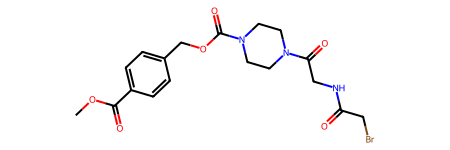

In [ ]:
query = df2.Structure[0]
query_fps = AllChem.RDKFingerprint(query, maxPath=5, fpSize=512)
query

Tanimoto similarity uses fingerprints. It would be best to use the same fingerprints that we trained the model with.

In [ ]:
all_Mfpts = [AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512) for mol in df2.Structure]

The following yields an array of values with tanimoto similarity

In [ ]:
from rdkit import DataStructs
Tanimoto_similarity = [DataStructs.FingerprintSimilarity(query_fps, x, metric=DataStructs.TanimotoSimilarity) for x in all_Mfpts]

We can store this in a dataframe.

,CID,Compound_Name,Smiles,Activity,Activity Value,Structure,tanimoto_values
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1,Active,1,,1.00
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...,Active,1,,0.40
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...,Active,1,,0.36
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...,Active,1,,0.56
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...,Active,1,,0.84
...,...,...,...,...,...,...,...
331,72205081,(2S)-5-oxo-2-[[(2S)-3-phenyl-2-(phenylmethoxyc...,Cc1c(C)[n+](C)c(SCC(=O)CCC(NC(=O)C(Cc2ccccc2)N...,Unspecified,0,,0.40
332,7054,Isatin,O=C1Nc2ccccc2C1=O,Unspecified,0,,0.35
333,3798517,"1-{4-[(2,3-Dioxo-2,3-dihydro-1H-indol-1-YL)met...",Cc1cc(CN2C(=O)C(=O)c3ccccc32)c(C)cc1CN1C(=O)C(...,Unspecified,0,,0.35
334,6020915,(E)-3-(3-hydroxyphenyl)-1-pyridin-3-ylprop-2-e...,O=C(C=Cc1cccc(O)c1)c1cccnc1,Unspecified,0,,0.30

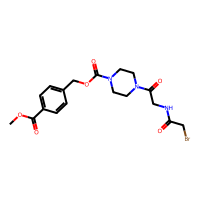
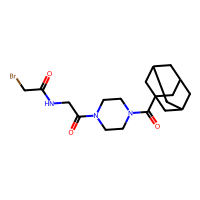
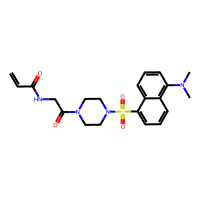
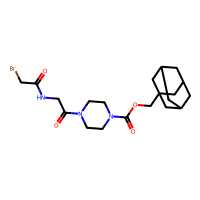
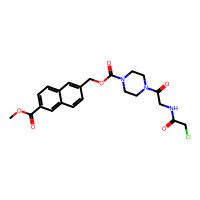
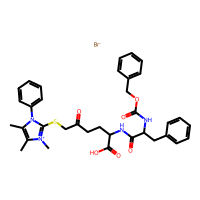
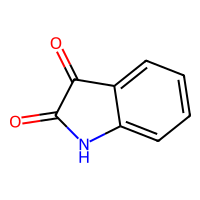
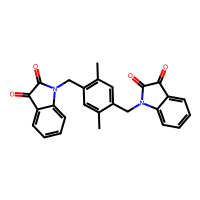
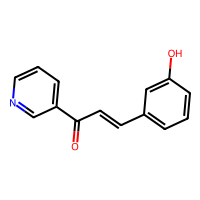
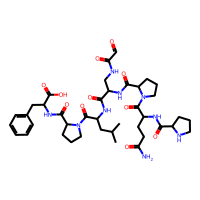

In [ ]:
df2["tanimoto_values"] = Tanimoto_similarity
df2_sorted = df2.sort_values(['tanimoto_values'],ascending=False)
df2

To visualize more clearly, create a grid of the tanimoto values.

Notice that the first molecule has a similarity coefficient of 1.0; Well that is becausing a molecule 1 is obviously 100% similar to itself.

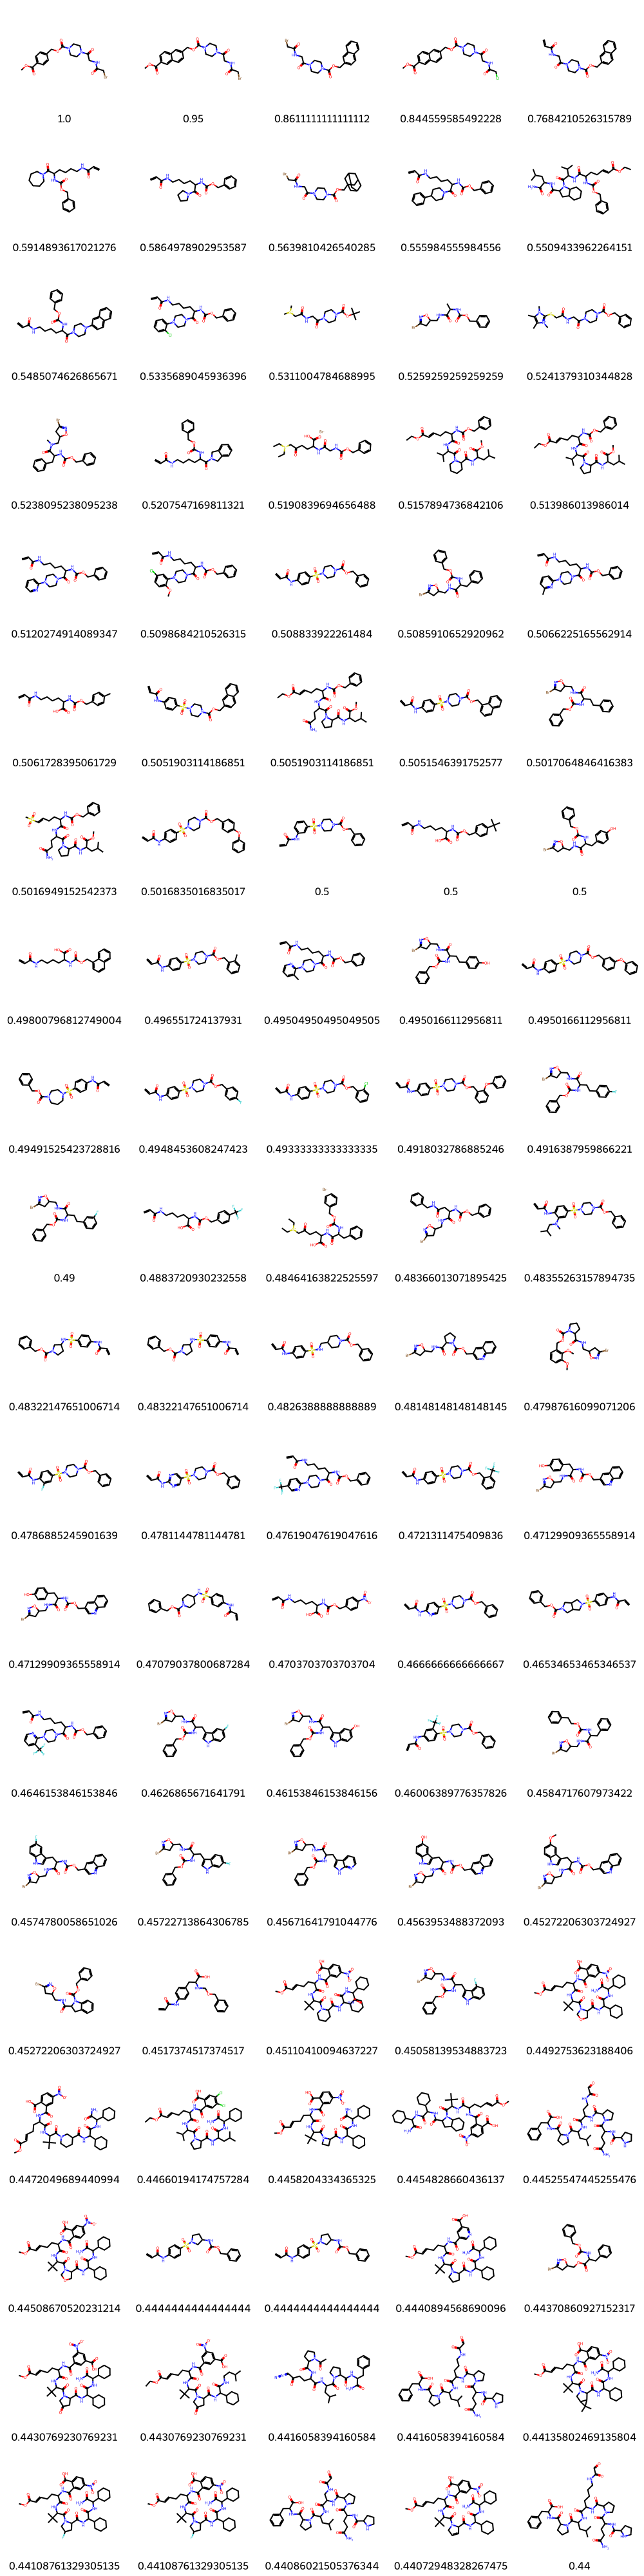

In [ ]:
structures_to_draw = []
legends = []

for x in df2_sorted["Structure"]:
    structures_to_draw.append(x)

legends = [str(x) for x in df2_sorted.tanimoto_values]

Draw.MolsToGridImage(structures_to_draw, maxMols=100, legends=legends, subImgSize=(200, 200), molsPerRow=5)

Overall, from these values which average in around the 0.40-0.50 range show us that most molecules are not insanely similarly to molecule 1.

If you think about, calculating similarity to the first molecule is just the small picture. We want to be able to compare every single molecule to each other. Let's do that now!

In [ ]:
dataset_matrix = df2[:336]
dataset_matrix

,CID,Compound_Name,Smiles,Activity,Activity Value,Structure,tanimoto_values
0,73504704,(4-Methoxycarbonylphenyl)methyl 4-[2-[(2-bromo...,COC(=O)c1ccc(COC(=O)N2CCN(C(=O)CNC(=O)CBr)CC2)cc1,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7d412f5922d0>,1.00
1,73775396,N-[2-[4-(adamantane-1-carbonyl)piperazin-1-yl]...,O=C(CBr)NCC(=O)N1CCN(C(=O)C23CC4CC(CC(C4)C2)C3...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7d412f592420>,0.40
2,73775533,N-[2-[4-[[5-(dimethylamino)-1-naphthyl]sulfony...,C=CC(=O)NCC(=O)N1CCN(S(=O)(=O)c2cccc3c(N(C)C)c...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7d412f592ea0>,0.36
3,73775247,1-Adamantylmethyl 4-[2-[(2-bromoacetyl)amino]a...,O=C(CBr)NCC(=O)N1CCN(C(=O)OCC23CC4CC(CC(C4)C2)...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7d412f592e30>,0.56
4,73775246,(6-Methoxycarbonyl-2-naphthyl)methyl 4-[2-[(2-...,COC(=O)c1ccc2cc(COC(=O)N3CCN(C(=O)CNC(=O)CCl)C...,Active,1,<rdkit.Chem.rdchem.Mol object at 0x7d412f5930d0>,0.84
...,...,...,...,...,...,...,...
331,72205081,(2S)-5-oxo-2-[[(2S)-3-phenyl-2-(phenylmethoxyc...,Cc1c(C)[n+](C)c(SCC(=O)CCC(NC(=O)C(Cc2ccccc2)N...,Unspecified,0,<rdkit.Chem.rdchem.Mol object at 0x7d412bc104a0>,0.40
332,7054,Isatin,O=C1Nc2ccccc2C1=O,Unspecified,0,<rdkit.Chem.rdchem.Mol object at 0x7d412bc10510>,0.35
333,3798517,"1-{4-[(2,3-Dioxo-2,3-dihydro-1H-indol-1-YL)met...",Cc1cc(CN2C(=O)C(=O)c3ccccc32)c(C)cc1CN1C(=O)C(...,Unspecified,0,<rdkit.Chem.rdchem.Mol object at 0x7d412bc10580>,0.35
334,6020915,(E)-3-(3-hydroxyphenyl)-1-pyridin-3-ylprop-2-e...,O=C(C=Cc1cccc(O)c1)c1cccnc1,Unspecified,0,<rdkit.Chem.rdchem.Mol object at 0x7d412bc105f0>,0.30


This algorithm essentially creates a table of the similarity coefficients between every pair of molecules.

Have you ever seen one of those head-to-head tables in sports standings which show the scores in every game displayed in a grid? We are essentially trying to do the same!

In [ ]:
from tqdm import tqdm

fpts_list = []

for mol in dataset_matrix['Structure']:
    fp = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512)
    fpts_list.append(fp)
dataset_matrix['m_fpt2']= fpts_list



for ind in tqdm(dataset_matrix.index):
    fp1 = dataset_matrix.at[ind,'m_fpt2']
    col_name = dataset_matrix.at[ind,'Structure']
    simlist = []

    for mol in dataset_matrix.Structure:
        fp = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512)
        sim =DataStructs.TanimotoSimilarity(fp1, fp)
        simlist.append(sim)
    dataset_matrix[col_name] = simlist

 76%|███████▋  | 257/336 [01:22<00:25,  3.10it/s]


KeyboardInterrupt: 

In [ ]:
dataset_matrix

Below we will create that head-head similarity table for all the molecules. However, we must remember that we are not concerned with observing every single value. We just care about the range the coefficients are in and we can simply just represent these with colors in a heatmap.

In [ ]:
# import seaborn as sn

# dataset_new = dataset_matrix.drop(['CID','Compound_Name','Smiles','Activity', 'Activity Value','Structure', 'tanimoto_values', 'm_fpt2'], axis=1)

# dataset_slice =  dataset_new.iloc[:336,:336]

# x = 335 # position of last inactive

# dataset_slice.columns = [str(i) for i in range(x+1)]

# m = 215 # position of last active

# fig, ax = plt.subplots(figsize=(6, 6))

# hm = sn.heatmap(data = dataset_slice, xticklabels = False, yticklabels = False)
# hm.axhline(y=m, color='yellow', linestyle='--', linewidth=1.5)
# hm.axvline(x=m, color='yellow', linestyle='--', linewidth=1.5)
# plt.text(m/2, 0, 'Active\n(1-216)\n', color='black', rotation=0, va='bottom', ha='center', fontsize = 15)
# plt.text(0, m/2, 'Active     \n(1-216)    ', color='black', rotation=0, va='bottom', ha='right', fontsize = 15)

# plt.text((x+m)/2, 0, 'Inactive\n(217-336)\n', color='black', rotation=0, va='bottom', ha='center', fontsize = 15)
# plt.text(0, (x+m)/2, 'Inactive     \n(217-336)   ', color='black', rotation=0, va='bottom', ha='right', fontsize = 15)
# plt.savefig("hm_sim.png", dpi = 600, bbox_inches='tight')
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sn

# Threshold value
threshold = 0.6

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Font size settings
font_size_title = 16
font_size_labels = 14
font_size_ticks = 12

# Main histogram for active molecules
ax1.hist(df_active_IC50_ranked['Value'].to_numpy(), bins=30, edgecolor='black', alpha=0.7, range=(0, 5), color='#FF7F00')
ax1.set_xlabel('IC50 [µM]', fontsize=font_size_labels)
ax1.set_ylabel('Samples', fontsize=font_size_labels)
ax1.set_title('IC50 Values of Active Molecules', fontsize=font_size_title)
ax1.margins(x=0)
ax1.axvline(x=threshold, color='blue', linestyle='--')
ax1.text(0.67, 50, 'Threshold: < 0.6µM', color='blue', fontsize=font_size_ticks, rotation=90)
ax1.tick_params(axis='x', labelsize=font_size_ticks)
ax1.tick_params(axis='y', labelsize=font_size_ticks)
ax1.grid(False)

# Create inset axis for active molecules
ax_inset = inset_axes(ax1, width="50%", height="50%", loc='center')

# Separate data into two groups based on threshold
data_left = df_active_IC50_ranked[df_active_IC50_ranked['Value'] < threshold]['Value']
data_right = df_active_IC50_ranked[df_active_IC50_ranked['Value'] >= threshold]['Value']

# Plot bars with different colors in inset
ax_inset.hist(data_left, bins=10, edgecolor='black', alpha=0.7, range=(0, threshold), color='lightcoral')
ax_inset.hist(data_right, bins=10, edgecolor='black', alpha=0.7, range=(threshold, 1), color='lightseagreen')

# Add vertical line for threshold in inset
ax_inset.axvline(x=threshold, color='blue', linestyle='--')
ax_inset.tick_params(axis='both', labelsize=font_size_ticks)
ax_inset.grid(False)

# Histogram for unspecified molecules
ic50_values2 = df_unspecified_IC50_ranked['Value'].to_numpy()
ax2.hist(ic50_values2, bins=50, edgecolor='black', alpha=0.7, range=(0, max(ic50_values2)), color='#FF7F00')
ax2.set_xlabel('IC50 [µM]', fontsize=font_size_labels)
ax2.set_ylabel('Samples', fontsize=font_size_labels)
ax2.set_title('IC50 Values of Unspecified Molecules', fontsize=font_size_title)
ax2.margins(x=0)
ax2.set_xticks([10, 50, 90, 130, 170, 210, 250, 290])
ax2.tick_params(axis='x', labelsize=font_size_ticks)
ax2.tick_params(axis='y', labelsize=font_size_ticks)
ax2.grid(False)

# Heatmap
dataset_new = dataset_matrix.drop(['CID', 'Compound_Name', 'Smiles', 'Activity', 'Activity Value', 'Structure', 'tanimoto_values', 'm_fpt2'], axis=1)
dataset_slice = dataset_new.iloc[:336, :336]
x = 335  # position of last inactive
dataset_slice.columns = [str(i) for i in range(x + 1)]
m = 215  # position of last active

hm = sn.heatmap(data=dataset_slice, xticklabels=False, yticklabels=False, ax=ax3)
hm.axhline(y=m, color='yellow', linestyle='--', linewidth=1.5)
hm.axvline(x=m, color='yellow', linestyle='--', linewidth=1.5)
ax3.text(m / 2, 0, 'Active\n(1-216)\n', color='black', rotation=0, va='bottom', ha='center', fontsize=15)
ax3.text(0, m / 2, 'Active     \n(1-216)    ', color='black', rotation=0, va='bottom', ha='right', fontsize=15)
ax3.text((x + m) / 2, 0, 'Inactive\n(217-336)\n', color='black', rotation=0, va='bottom', ha='center', fontsize=15)
ax3.text(0, (x + m) / 2, 'Inactive     \n(217-336)   ', color='black', rotation=0, va='bottom', ha='right', fontsize=15)

# Save and show plot
plt.tight_layout()
plt.savefig("combined_ic50_heatmap.png", dpi=1400, bbox_inches='tight')
plt.show()


The heatmap key indicates the range each similarity coefficient is in with a lighter color indicating "more similar."

When we generate these, we want to see that the majority of the heatmap is dark with a similarity coefficient < 0.6. It is ok if there are a few larger light clusters with high similarity coefficients; there will be some molecules that are quite similar.

By observing the heatmap for our data, we can conclude that we have indeed obtained a reliable dataset with a suitable training difficulty.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

models = ['DummyClassifier (Baseline)', 'MPGraphNN (Chemprop)', 'Boosted Random Forest', 'Boosted MLPerceptron']
accuracy_scores = [64, 88, 92, 93]
auc_scores = [50, 88, 90, 91]
f1_scores = [64, 91, 93, 95]

plt.figure(figsize=(14, 8))  # Larger width for landscape layout

bar_width = 0.2  # adjust the width as needed
index = range(len(models))

plt.bar(index, accuracy_scores, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], auc_scores, bar_width, label='AUC')
plt.bar([i + 2 * bar_width for i in index], f1_scores, bar_width, label='F1-Score')

plt.xlabel('Models', fontsize=14)  # Increase font size for better visibility
plt.ylabel('Score', fontsize=14)

# Increase x-axis tick spacing to avoid overlapping bars
plt.xticks([i + 1.5 * bar_width for i in index], models, rotation=45, ha='right', fontsize=14, fontweight='bold')  # adjust rotation and ha as needed
plt.yticks(np.arange(0, 101, 10), fontsize=14)  # Adjust the spacing between y-axis ticks and increase font size

plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("plz_hurry.png", dpi=1000)
plt.show()

